In [1]:
import os
import numpy as np
import pandas as pd
import calendar
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import holidays
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

# for display Japanese characters on matplotlib plots, need to install the font first
fp = fm.FontProperties(fname=os.path.expanduser('~/Library/Fonts/NotoSansJP-Regular.ttf'))
plt.rcParams['font.family'] = fp.get_name()

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

## Define Helper Functions

In [2]:
def yen_or_num_formatter(yen=False, decimals=0):
    """
    Format axis tick labels as Japanese yen or abbreviated numbers. 

    Parameters
    ----------
    yen : logical (default=False)
        If True, will add ¥ in front of the numbers.
    decimals : int (default=0)
        Number of decimals to display.
        
    Returns
    -------
    Function that does the formmating.
    """
    base_fmt = '%.{}f%s'.format(decimals)
    if yen:
        base_fmt = '¥' + base_fmt
    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

In [3]:
def dodged_barplot(df, xvar, yvar, gpvar=None, title=None, xlab=None, ylab=None, 
                   y_as_pct=False, y_as_yen=False, y_decimals=0, yticks=8,
                   alpha=0.8, width=10, height=4, bar_label_decimals=0, ):
    """
    Plot dodged bar charts.

    Parameters
    ----------
    df : data frame
    xvar : str
        Name of a categorical variable in the input data frame, to be shown on x-axis.
    yvar : str
        Name of a continuous variable in the input data frame, to be shown on y-axis.
    gpvar : str (default = None)
        Name of a categorical variable in the input data frame, to be used as the
        grouping variable for dodged bars. 
    title, xlab, ylab : str (default = None)
        Figure title, x-label and y-label. By default, we use xvar as xlabel and 
        yvar as ylabel. To remove xlabel or ylabel, set `xlab=''` or `ylab=''`.
    y_as_pct : logical (default = False)
        Whether to format y-tick labels as %.
    y_as_yen : logical (default = False)
        Whether to format y-tick labels as ¥.
    y_decimals : int (default = 0)
        How many decimal points to show on y-tick labels.
    yticks : int  (default = 8)
        Number of y-ticks. 
    alpha : float (default = 0.7)
        Color transparency.
    width : float (default = 10)
        Figure width (in inches).
    height : float (default = 4)
        Figure height (in inches).
    bar_label_decimals : int (default = 0)
        Number of decimals to show on bar labels.

    Returns
    -------
    None. Display the plot as side effect.
    """
    # draw plot using seaborn 
    g = sns.catplot(data=df, x=xvar, y=yvar, hue=gpvar, kind='bar', alpha=alpha,
        legend_out=False)
    if xlab is None: 
        xlab = xvar    
    if ylab is None:
        ylab = yvar
    g.set(title=title, xlabel=xlab, ylabel=ylab)

    for ax in g.axes.flat:
        # format axes
        if y_as_yen:
            ax.yaxis.set_major_formatter(yen_or_num_formatter(True, y_decimals))
            bar_label_fmt = "¥{:." + str(bar_label_decimals) + "f}" 
        elif y_as_pct:
            ax.yaxis.set_major_formatter(PercentFormatter(1, y_decimals))
            bar_label_fmt = "{:." + str(bar_label_decimals) + "%}"
        else: 
            bar_label_fmt = "{:." + str(bar_label_decimals) + "f}" 
        # add bar labels
        for p in ax.patches:
            xpos = p.get_x() + p.get_width()/2
            ypos = p.get_height()
            if ypos > 0:
                ax.annotate(bar_label_fmt.format(p.get_height()), 
                            xy=(xpos, ypos), va='bottom', ha='center')
            else: 
                ax.annotate(bar_label_fmt.format(p.get_height()), 
                            xy=(xpos, ypos), va='top', ha='center')

    # show granular ticks on the axes, including the min and max values
    # only do this if y values are floats, don't do it for ints (count data)
    if df[yvar].dtypes == float:
        y = np.append(df[yvar].values, 0)
        steps = (y.max() - y.min()) / yticks
        plt.yticks(np.arange(y.min(), y.max()+steps, steps))

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    
    # ensure nothing out of plotting area when saving the figure
    plt.tight_layout()

In [4]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=12,
            va="center",
        )
    return ax

In [5]:
def check_stationarity(x: pd.Series, sig_level=0.01):
    """
    Check if a time series is stationary.
    H0: unit root exists (non-stationary). 
    So if the p-value is less than `sig_level`, we'd reject H0 and conclude the 
    series is stationary.

    Parameters
    ----------
    x : Series
    sig_level : float
        Significance level below which we'd conclude statistical significance.
    """

    pval = adfuller(x)[1]  # the augmented Dickey– Fuller test
    msg = 'p-value = ' + str(round(pval, 4)) + ', and the ' 
    if x.name != None:
        msg += x.name + ' time series'
    if pval < sig_level:
        print(msg + ' is likely stationary.')
        return True
    else:
        print(msg + ' is likely non-stationary.')
        return False

In [6]:
def MAPE(actuals, predictions):
    """ Calculate mean absolute percentage error """
    return (abs(actuals - predictions) / actuals).mean()

## Read and Clean Data

In [7]:
# read individual files
txs = pd.read_csv('transactions.csv', parse_dates=['event_occurrence'])\
    .rename(columns={'id':'tx_id'})
stores = pd.read_csv('stores.csv').rename(columns={'id':'store_id'})
users = pd.read_csv('users.csv').rename(columns={'id':'user_id'})

# left join transactions data with stores and users data to get one frame
# at the transaction level, and we'll build all analyses from this frame.
df = pd.merge(txs, stores, how='left', on='store_id')
df = pd.merge(df, users, how='left', on='user_id')

# sanity check
print('how many txs without any stores:', df['store_id'].isnull().sum()) 
print('how many txs without any users:', df['user_id'].isnull().sum())
df.head()

how many txs without any stores: 0
how many txs without any users: 0


tx_id                               user_id  \
0  a555eb55-1da4-6087-b5ab-06b35b608002  93098549-3ff0-e579-01c3-df9183278f64   
1  f699b867-e70c-5160-90c8-7dfa32dce0da  35ba9da1-98d0-cbb7-7844-e648601b7208   
2  5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591  63cb5ee0-a457-9975-5455-4d76109bc754   
3  f033da1a-bafb-5faa-67e3-c76b07b04333  786fcb82-40cf-1dc9-b9ba-2541502ca95a   
4  ccc35ffe-ee42-b696-783c-6670bfd800ec  acc814f5-beb6-db35-64f1-52f7c5a8466c   

                               store_id           event_occurrence  amount  \
0  a3c7874b-75df-9cf2-62ab-cf58be5d9e0e 2020-01-01 06:40:43.323987     315   
1  1d59adf3-94f2-f5f8-46c6-8558c544a3a9 2020-01-01 07:04:25.968615    1646   
2  c835f09d-ac5b-2005-1959-f452456a746a 2020-01-01 07:06:16.164563     385   
3  eaf4c05d-13e1-7c8a-9ae0-cf2ec2e3dcd2 2020-01-01 07:07:26.029685     166   
4  a8301ae2-df3b-ffe4-0279-c74af1dbb847 2020-01-01 07:12:24.448015     656   

             nam           laa   category   lat    lon gender   age  
0    Saitama Ken      Soka Shi       コンビニ 35.83 139.81      M 88.00  
1      Gunma Ken     Meiwa Cho     ショッピング 36.22 139.56      M 44.00  
2  Hiroshima Ken  Fukuyama Shi       コンビニ 34.64 133.26      M 16.00  
3       Tokyo To     Nerima Ku        グルメ 35.76 139.66      F 79.00  
4       Tokyo To    Edogawa Ku  スーパーマーケット 35.69 139.86      F 79.00

In [8]:
# check and deal with missing gender
print('Before NA treatment:', df['gender'].unique())
df['gender'] = df['gender'].fillna('OTHER')
print('After NA treatment:', df['gender'].unique())


Before NA treatment: ['M' 'F' nan 'OTHER']
After NA treatment: ['M' 'F' 'OTHER']


In [9]:
# replace missing age with 999
print('Number of rows with age missing:', df['age'].isna().sum())
df['age'] = df['age'].fillna(999)
print('After NA treatment, number of rows with age missing:', df['age'].isna().sum())

Number of rows with age missing: 76646
After NA treatment, number of rows with age missing: 0


In [10]:
# extract date time features
df['year'] = df['event_occurrence'].dt.year
df['quarter'] = df['event_occurrence'].dt.quarter
df['yearmon'] = df['event_occurrence'].dt.to_period('M')
df['month'] = df['event_occurrence'].dt.month
df['week'] = df['event_occurrence'].dt.isocalendar().week.astype('int64')
df['dayofweek'] = df['event_occurrence'].dt.dayofweek
# df['is_weekend'] = df['dayofweek'] >= 5
df['date'] = df['event_occurrence'].dt.date
df['hour'] = df['event_occurrence'].dt.hour
jp_holidays = holidays.country_holidays('JP')
df['holiday'] = [jp_holidays.get(dt) for dt in df['date']]
df['is_holiday'] = ~df['holiday'].isna()

In [11]:
print("The dataset contains {:,} transactions between {:,} buyers and {:,} stores from {} to {}."\
    .format(df.tx_id.nunique(), df.user_id.nunique(), df.store_id.nunique(), 
            df.date.min(), df.date.max()))

The dataset contains 1,582,260 transactions between 9,542 buyers and 95,460 stores from 2020-01-01 to 2021-12-31.


## Exploratory Analysis

In [12]:
# define some data prep helper functions for reuse
def prep_data_yoy(df, index_var='month'):
    # aggregate GMV by index_var and year
    da = pd.pivot_table(
        df, 
        index=[index_var],
        columns='year',
        values=['amount'],
        aggfunc='sum',
        fill_value=0
    )
    da.columns = da.columns.get_level_values(1).astype(str)
    da.columns.name = None
    da['YoY'] = da['2021'] / da['2020'] - 1
    if index_var == 'month':
        da.index = calendar.month_abbr[1:]
        da.index.name = index_var

    # change to long format
    da_long = da[['2020', '2021']].stack().reset_index()\
        .rename(columns={0:'GMV', 'level_1':'year'})
    da_long['GMV'] /= 1e6

    # return both since we'll need both for plotting
    return [da, da_long]

def prep_data_date_by_season(df, col_var='hour'):    
    # aggregate GMV by year, date, and col_var
    da = pd.pivot_table(
        df, 
        index=['year', 'date'],
        columns=col_var,
        values=['amount'],
        aggfunc='sum',
        fill_value=0
    )
    # clean up columns and index
    da.columns = da.columns.get_level_values(1).astype(str)
    da.columns.name = None
    # da.head()

    # change to long format
    da_long = da.stack().reset_index()\
        .rename(columns={0:'GMV', 'level_2':col_var})
    # da_long.head()
    
    # return both since we might need both for plotting
    return [da, da_long]

### YoY Comparison of Monthly Total GMVs

Comparing the monthly total GMVs for YayYay as a whole between 2020 and 2021, we see a huge growth, in particular, the YoY growths for April to December are all above 80%.

In [13]:
da_wide, da_long = prep_data_yoy(df, 'month')

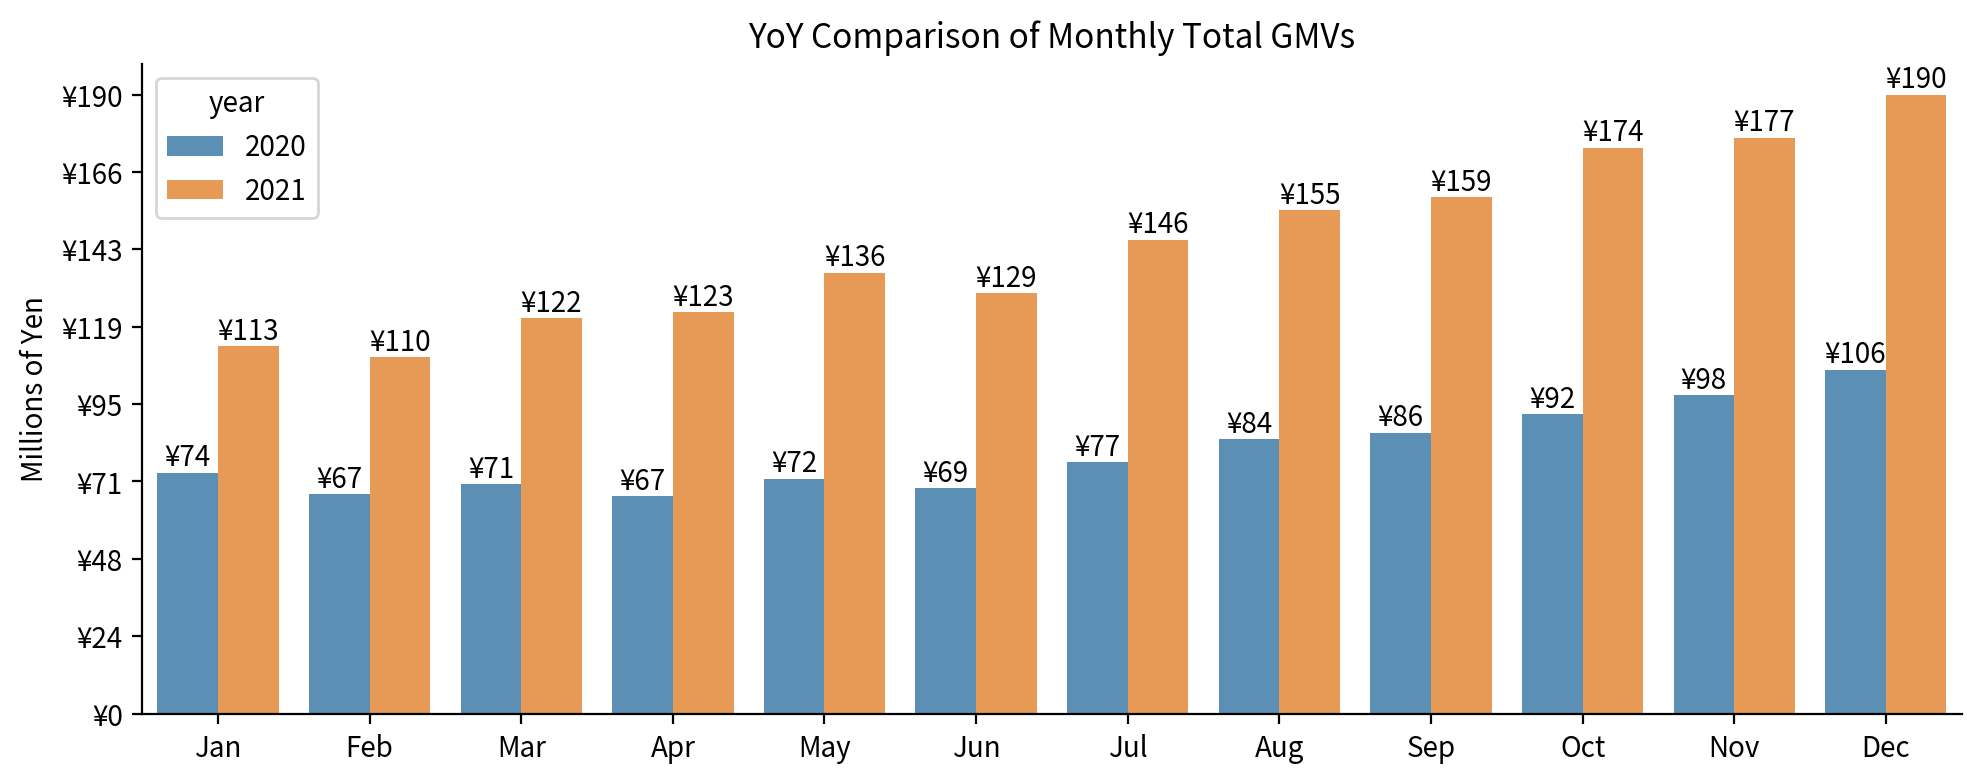

In [14]:
dodged_barplot(
    da_long, 'month', 'GMV', gpvar='year', 
    title='YoY Comparison of Monthly Total GMVs', 
    xlab='', ylab='Millions of Yen', y_as_yen=True)

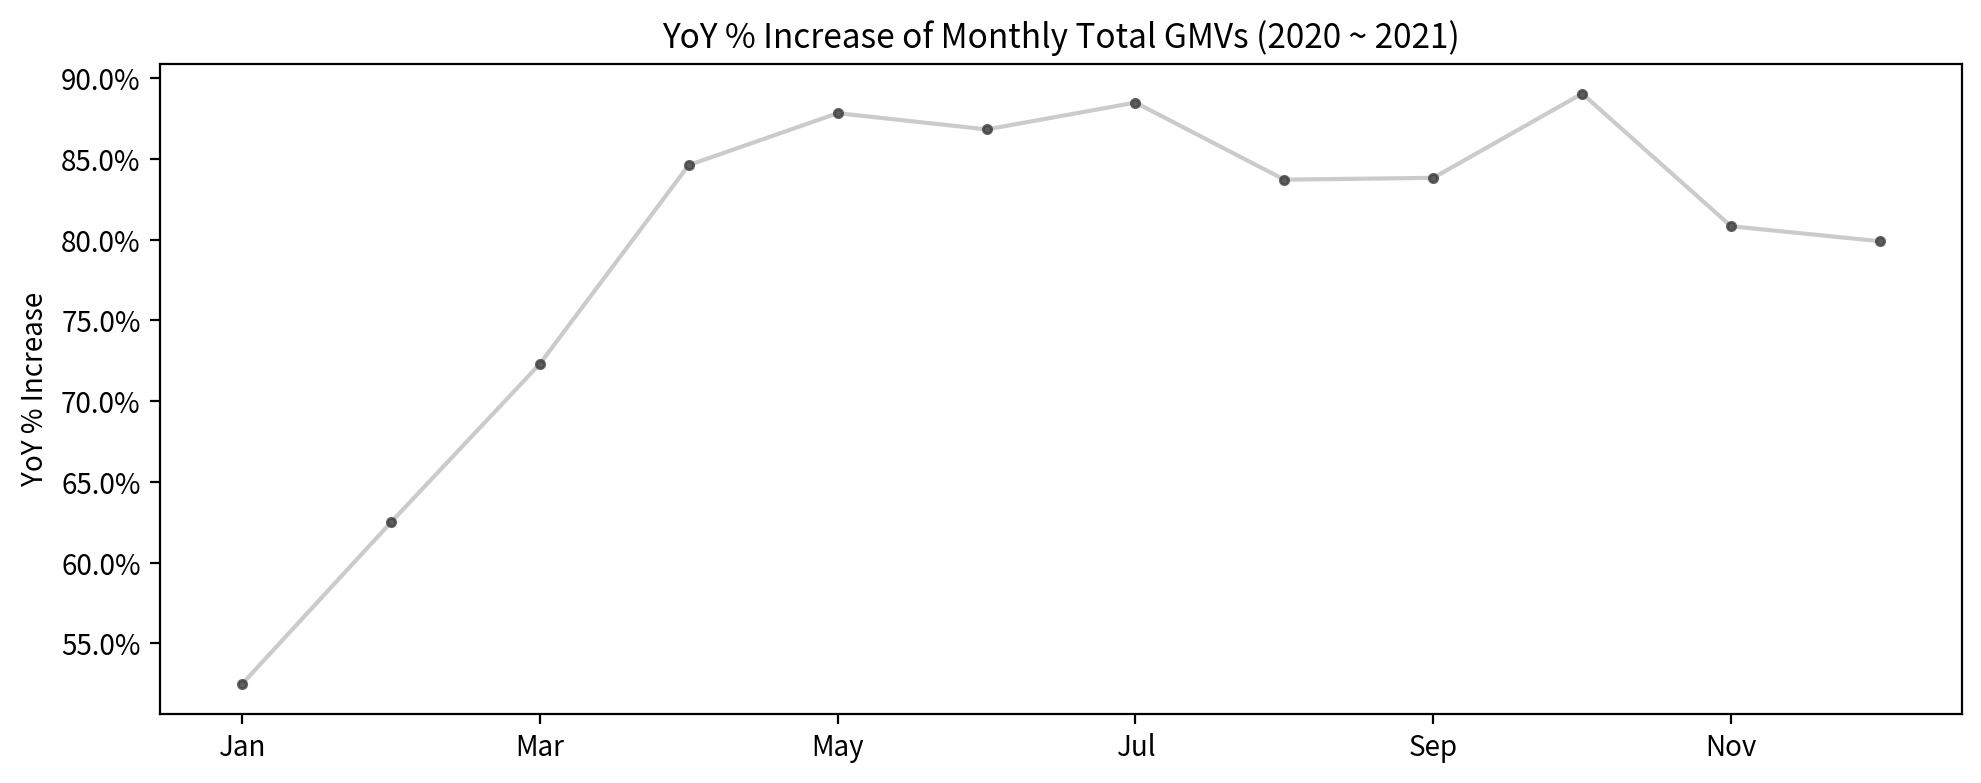

In [15]:
ax = da_wide['YoY'].plot(**plot_params, alpha=0.8, figsize=(10, 4))
ax.set(title='YoY % Increase of Monthly Total GMVs (2020 ~ 2021)', 
       xlabel='', ylabel='YoY % Increase')
ax.yaxis.set_major_formatter(PercentFormatter(1, 1))
plt.tight_layout();

### Comparison of Annual Total GMVs by Store Type

Comparing the total GMVs between 2020 and 2021, we see at least 75% growth across all types of stores. In particular, '家電・携帯電話' had 93% increase.

In [16]:
da_wide, da_long = prep_data_yoy(df, 'category')

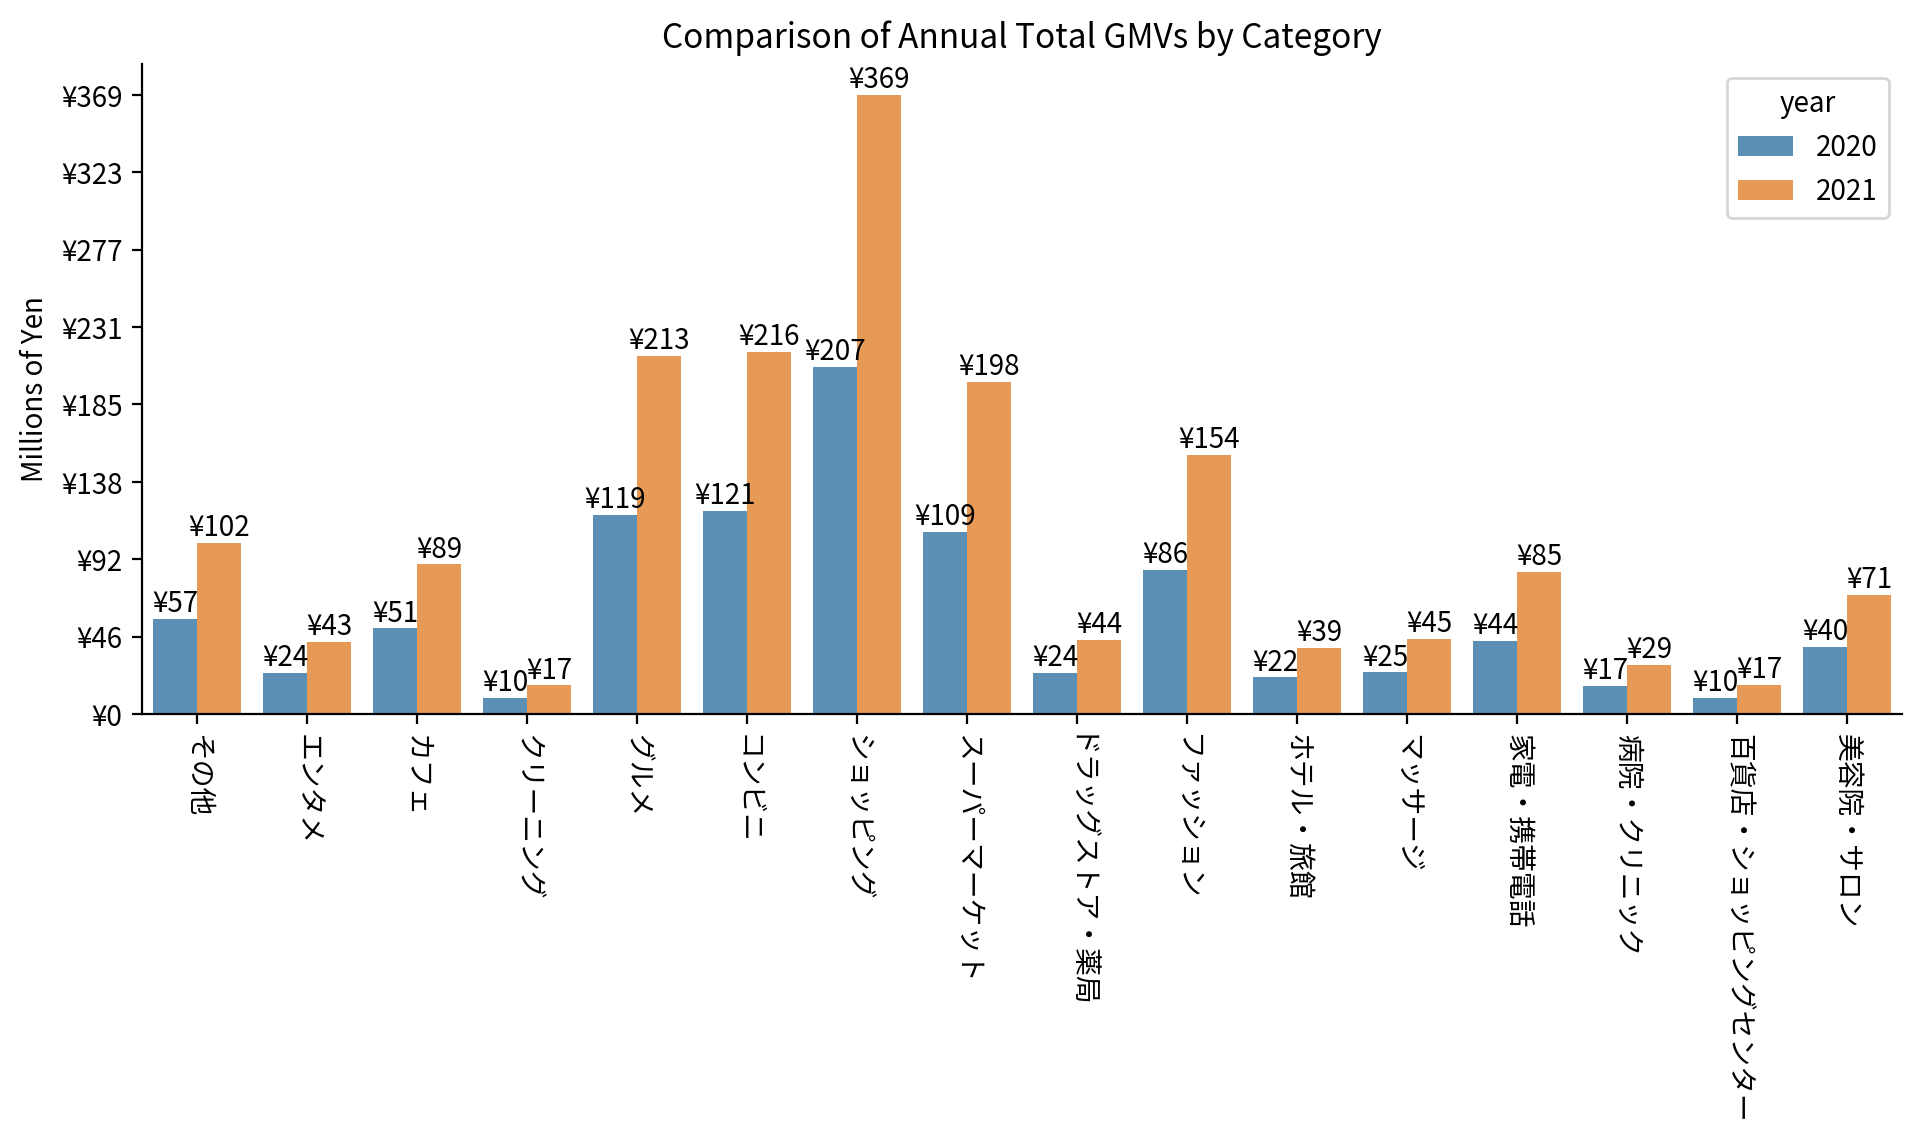

In [17]:
dodged_barplot(
    da_long, 'category', 'GMV', gpvar='year', 
    title='Comparison of Annual Total GMVs by Category', 
    xlab='', ylab='Millions of Yen', y_as_yen=True)
plt.xticks(rotation=270);

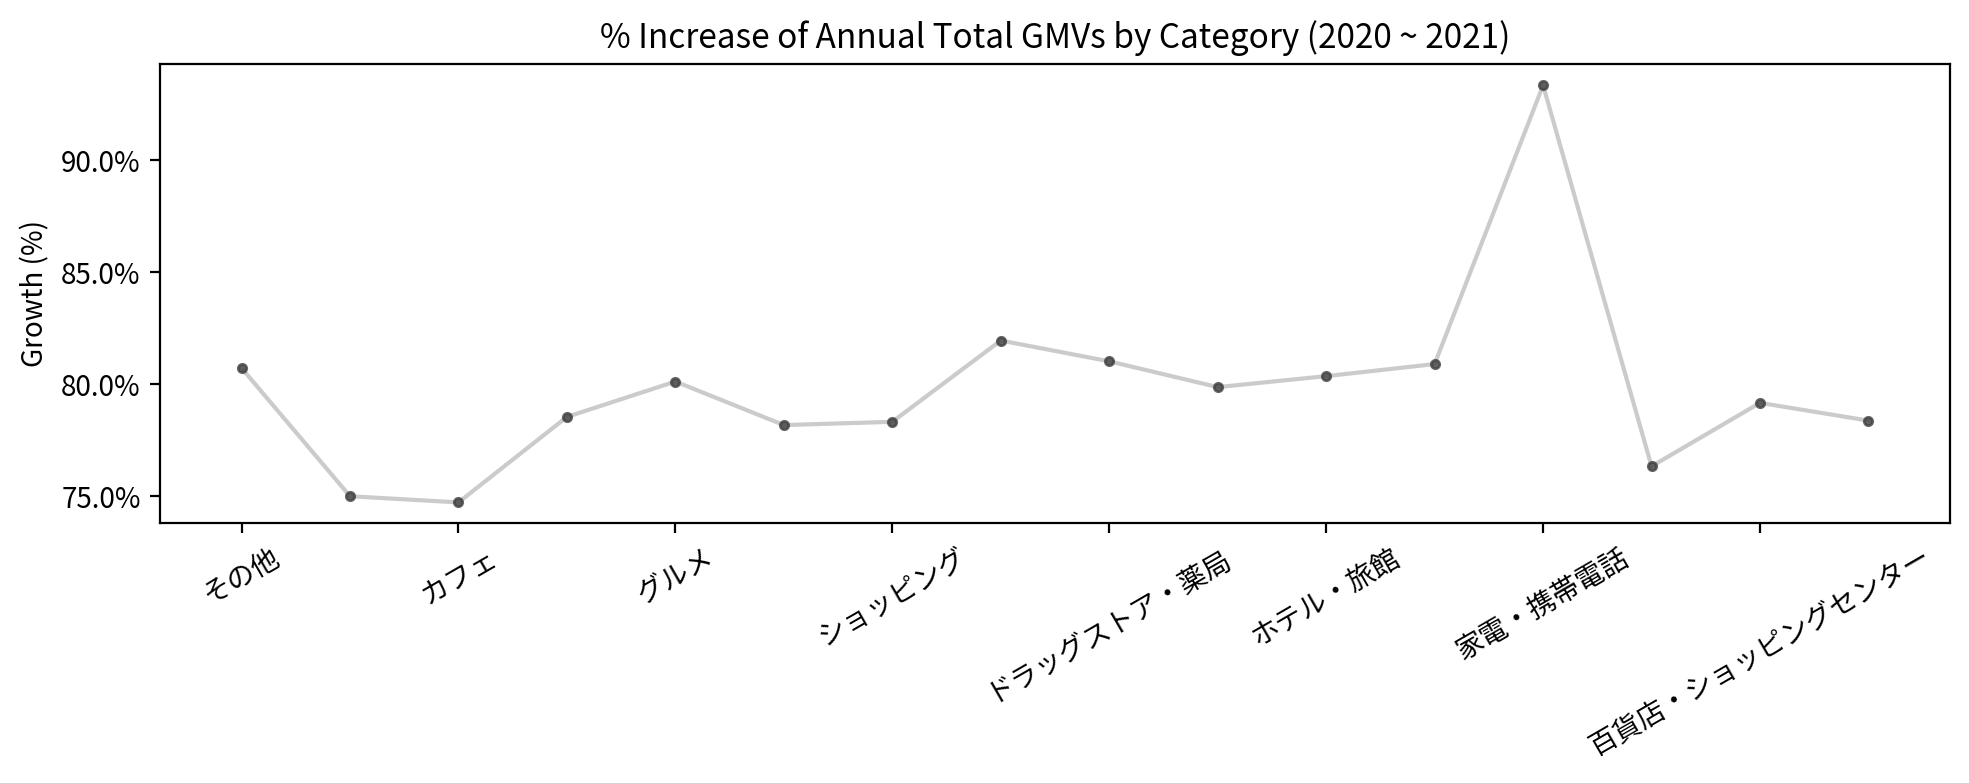

In [18]:
ax = da_wide['YoY'].plot(**plot_params, alpha=0.8, figsize=(10, 4))
ax.set(title='% Increase of Annual Total GMVs by Category (2020 ~ 2021)', 
       xlabel='', ylabel='Growth (%)')
ax.yaxis.set_major_formatter(PercentFormatter(1, 1))
plt.xticks(rotation=30)
plt.tight_layout();

### Compare by Gender and Age

- Male spent ~32.4% more than females in 2020 and ~30.8% more than females in 2021.
- The spending pattern for different aged people are consistent in these two years. People between 30 and 59 spent the most. People between 60 and 80 spent somewhat less. People older than 83 spent only a little.

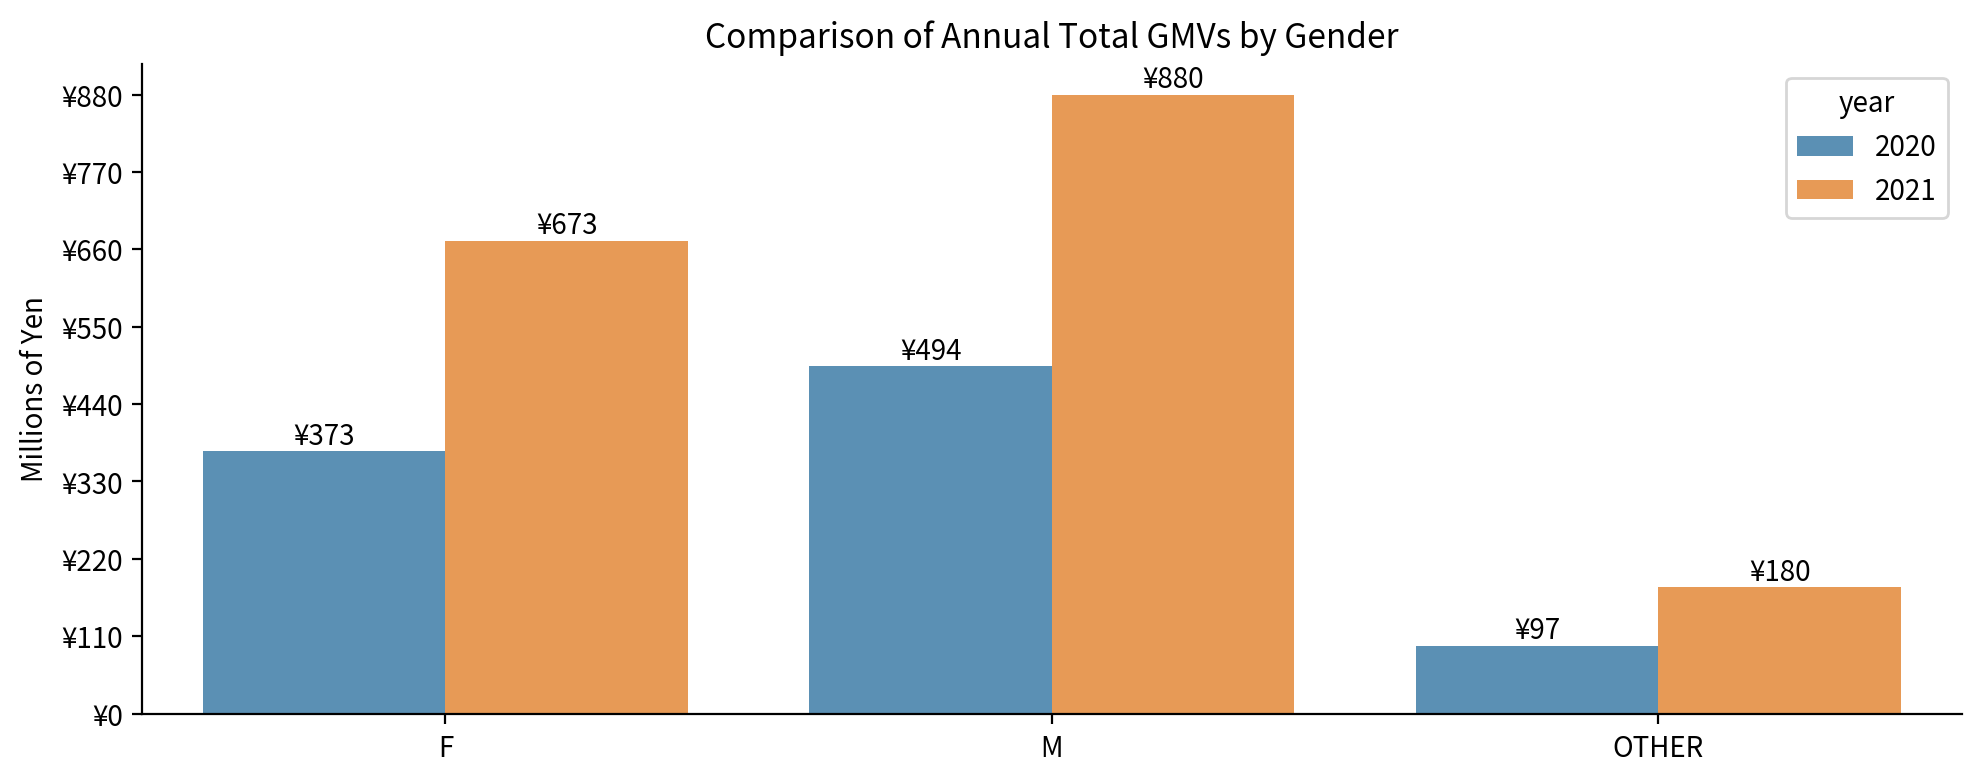

In [19]:
da_wide, da_long = prep_data_yoy(df, 'gender')
dodged_barplot(
    da_long, 'gender', 'GMV', gpvar='year', 
    title='Comparison of Annual Total GMVs by Gender', 
    xlab='', ylab='Millions of Yen', y_as_yen=True)

In [20]:
da_wide, da_long = prep_data_yoy(df, 'age')
da_wide = da_wide[da_wide.index != 999]

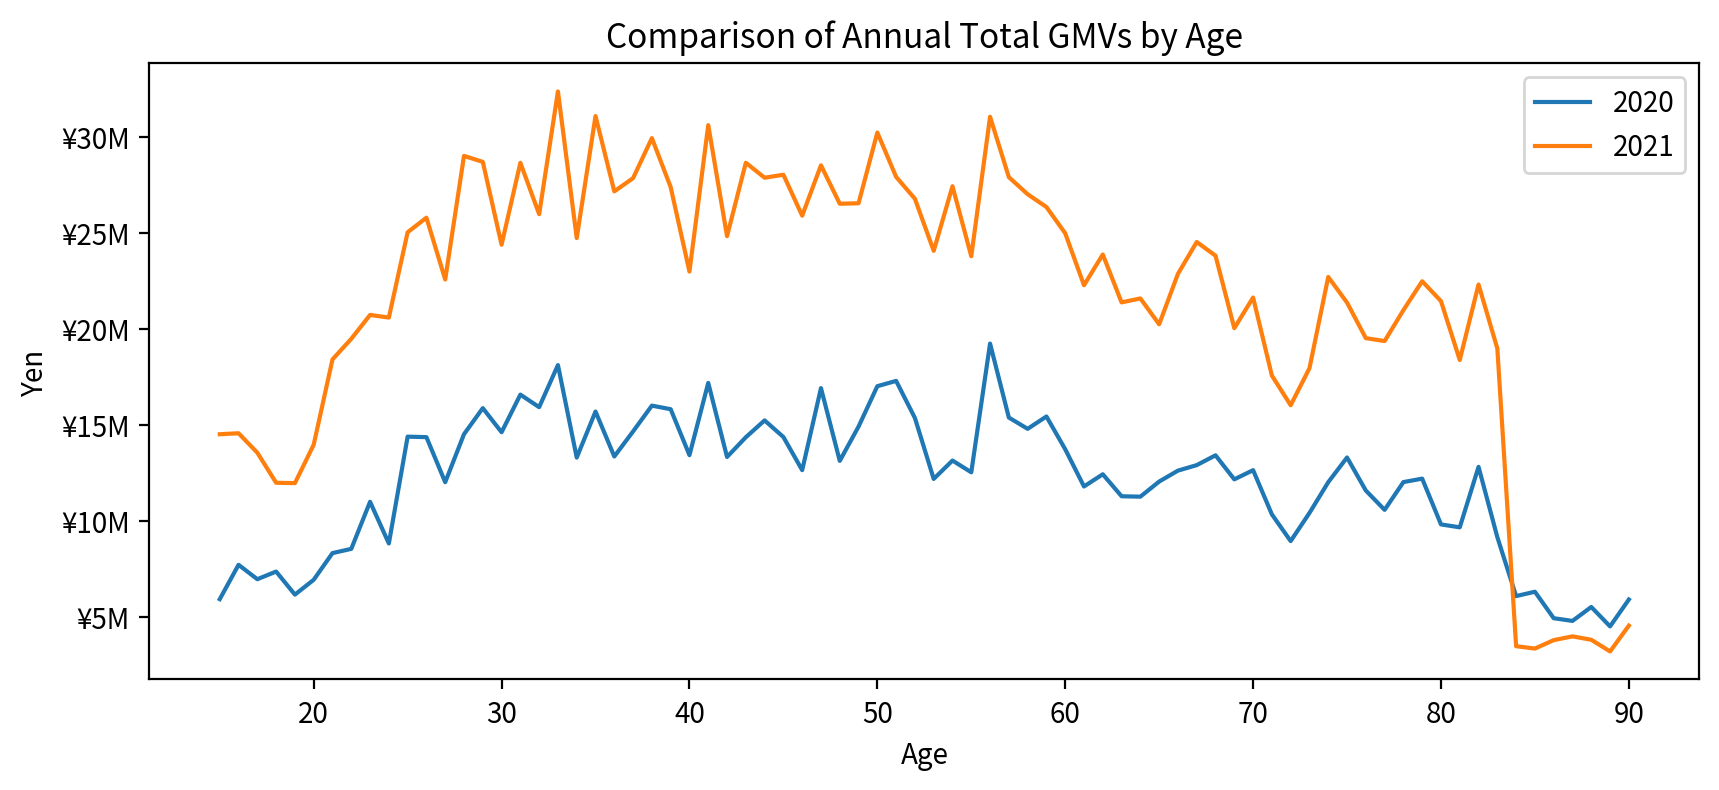

In [21]:
fig, ax = plt.subplots(1, 1, alpha=0.8, figsize=(10, 4))
ax.plot(da_wide.index, da_wide['2020'])
ax.plot(da_wide.index, da_wide['2021'])
ax.yaxis.set_major_formatter(yen_or_num_formatter(True, 0))
ax.set(title='Comparison of Annual Total GMVs by Age', xlabel='Age', ylabel='Yen')
plt.legend(["2020", '2021'])
plt.show()

### Segment Stores

- New Stores: stores that started using YayYay's product in 2021.
- Churned Stores: stores that stopped using YayYay's product in 2021.
- Retained Stores: stores that used YayYay's product in both 2020 and 2021.
  - Laggard: stores with significant drop in usage in 2021. These stores are about to churn.
  - High Growth Stores: stores with significant increase in usage in 2021. 

Future investigation: can do a full-fledged churn analysis on stores.

In [80]:
da_wide, da_long = prep_data_yoy(df, 'store_id')

# find stores that started using YayYay's product in 2021 and print top 10
cond = (da_wide['2020'] == 0) & (da_wide['2021'] > 0)
new_stores = da_wide[cond].sort_values('2021', ascending=False)
print('Top 10 New Stores in 2021:')
print(new_stores.head(10), end='\n\n')

# find stores that stopped using YayYay's product in 2021 and print top 10 (based on 2020 GMV)
cond = (da_wide['2020'] > 0) & (da_wide['2021'] == 0)
churned_stores = da_wide[cond].sort_values('2020', ascending=False)
print('Top 10 Churned Stores in 2021:')
print(churned_stores.head(10), end='\n\n')

Top 10 New Stores in 2021:
                                      2020    2021  YoY
store_id                                               
fcae3d89-6a09-2486-c052-fb1681eb25a5     0  258454  inf
61de0c19-40c2-6c1b-b249-3225feed3265     0  252726  inf
1d52b0db-807b-8e7f-fed0-611d5ce622e2     0  189066  inf
451a8e6f-300f-548a-0b5d-5180e0c489af     0  160931  inf
07883d69-a6d4-7343-a969-c936406f5b05     0  159754  inf
1211e981-a2e1-2a4f-426c-94037b15196a     0  147464  inf
aebbd3be-2bc9-8603-e1de-4004abc44bf2     0  144259  inf
5126b895-3a6b-c277-3ddb-e3ae9969fa6f     0  140674  inf
b683d9af-4113-5ce5-347e-15e2aa6d9060     0  138799  inf
e1043753-d679-a8af-63e3-98d6029b11d8     0  122886  inf

Top 10 Churned Stores in 2021:
                                        2020  2021   YoY
store_id                                                
0e1ce110-0b0f-9fec-5552-8a884f154b7b  129862     0 -1.00
0a3d797e-7dde-4b83-4de7-c5e0d509c105   95146     0 -1.00
ed205286-86ab-77e6-d2af-d4296a7ca546   91

In [82]:
# find top 10 stores with the biggest growth from 2020 to 2021
cond = (da_wide['2020'] > 0) & (da_wide['2021'] > 0)
retained_stores = da_wide[cond].sort_values('YoY', ascending=False)
print('Top 10 Stores with the biggest growth from 2020 to 2021:')
print(retained_stores.head(10), end='\n\n')

# find top 10 stores with the biggest drop from 2020 to 2021
retained_stores = da_wide[cond].sort_values('YoY', ascending=True)
print('Top 10 Stores with the biggest drop from 2020 to 2021:')
print(retained_stores.head(10))

Top 10 Stores with the biggest growth from 2020 to 2021:
                                      2020    2021       YoY
store_id                                                    
db921d0d-a7b0-8d9a-1547-3d7e1d858831     4   52762 13,189.50
81459ed1-7b3b-f66d-c6f6-1efd2f0129d5     4   36927  9,230.75
8e579937-2ba6-3ca7-384b-0253fb9a9e11    27  150312  5,566.11
5a0ce366-3927-ca58-4cd2-bd8dbf717273    20   94966  4,747.30
c2ecd670-94a2-89ec-2963-f6700dc01ad2    12   55329  4,609.75
e5483243-611f-5ca2-a74b-407da6926604   158  710042  4,492.94
66ce2255-9bb1-8be3-10e5-56ac9dad0ea1    27   69132  2,559.44
6da73440-49af-45d8-7df3-c823d3ca273a   201  506809  2,520.44
302ebebd-be65-98c3-0f9a-24f48b0a756b    11   22461  2,040.91
d23332b9-8d33-e78d-23cf-35a619b7ac26    45   80590  1,789.89

Top 10 Stores with the biggest drop from 2020 to 2021:
                                        2020  2021   YoY
store_id                                                
e3913ac9-c843-b5db-5b9a-0afc514fdcaa   25

### Hourly, DayofWeek, Monthly, and Quarterly Patterns

In [22]:
def mk_boxplot_gmv_by_season(df, xvar, yvar, gpvar=None):    
    season = df[xvar].name.capitalize()
    df2020, df2021 = df[df.year==2020], df[df.year==2021]
    _, (ax0, ax1) = plt.subplots(2, 1, alpha=0.8, figsize=(10, 6))
    # plot 2020 data
    sns.boxplot(data=df2020, x=xvar, y=yvar, ax=ax0)
    ax0.yaxis.set_major_formatter(yen_or_num_formatter(True, 1))
    ax0.set(title='Distribution of GMV by {} (2020)'.format(season), 
           xlabel=season, ylabel='Yen')
    # plot 2021 data
    sns.boxplot(data=df2021, x=xvar, y=yvar, ax=ax1)
    ax1.yaxis.set_major_formatter(yen_or_num_formatter(True, 1))
    ax1.set(title='Distribution of GMV by {} (2021)'.format(season), 
           xlabel=season, ylabel='Yen')
    plt.tight_layout()
    plt.show()

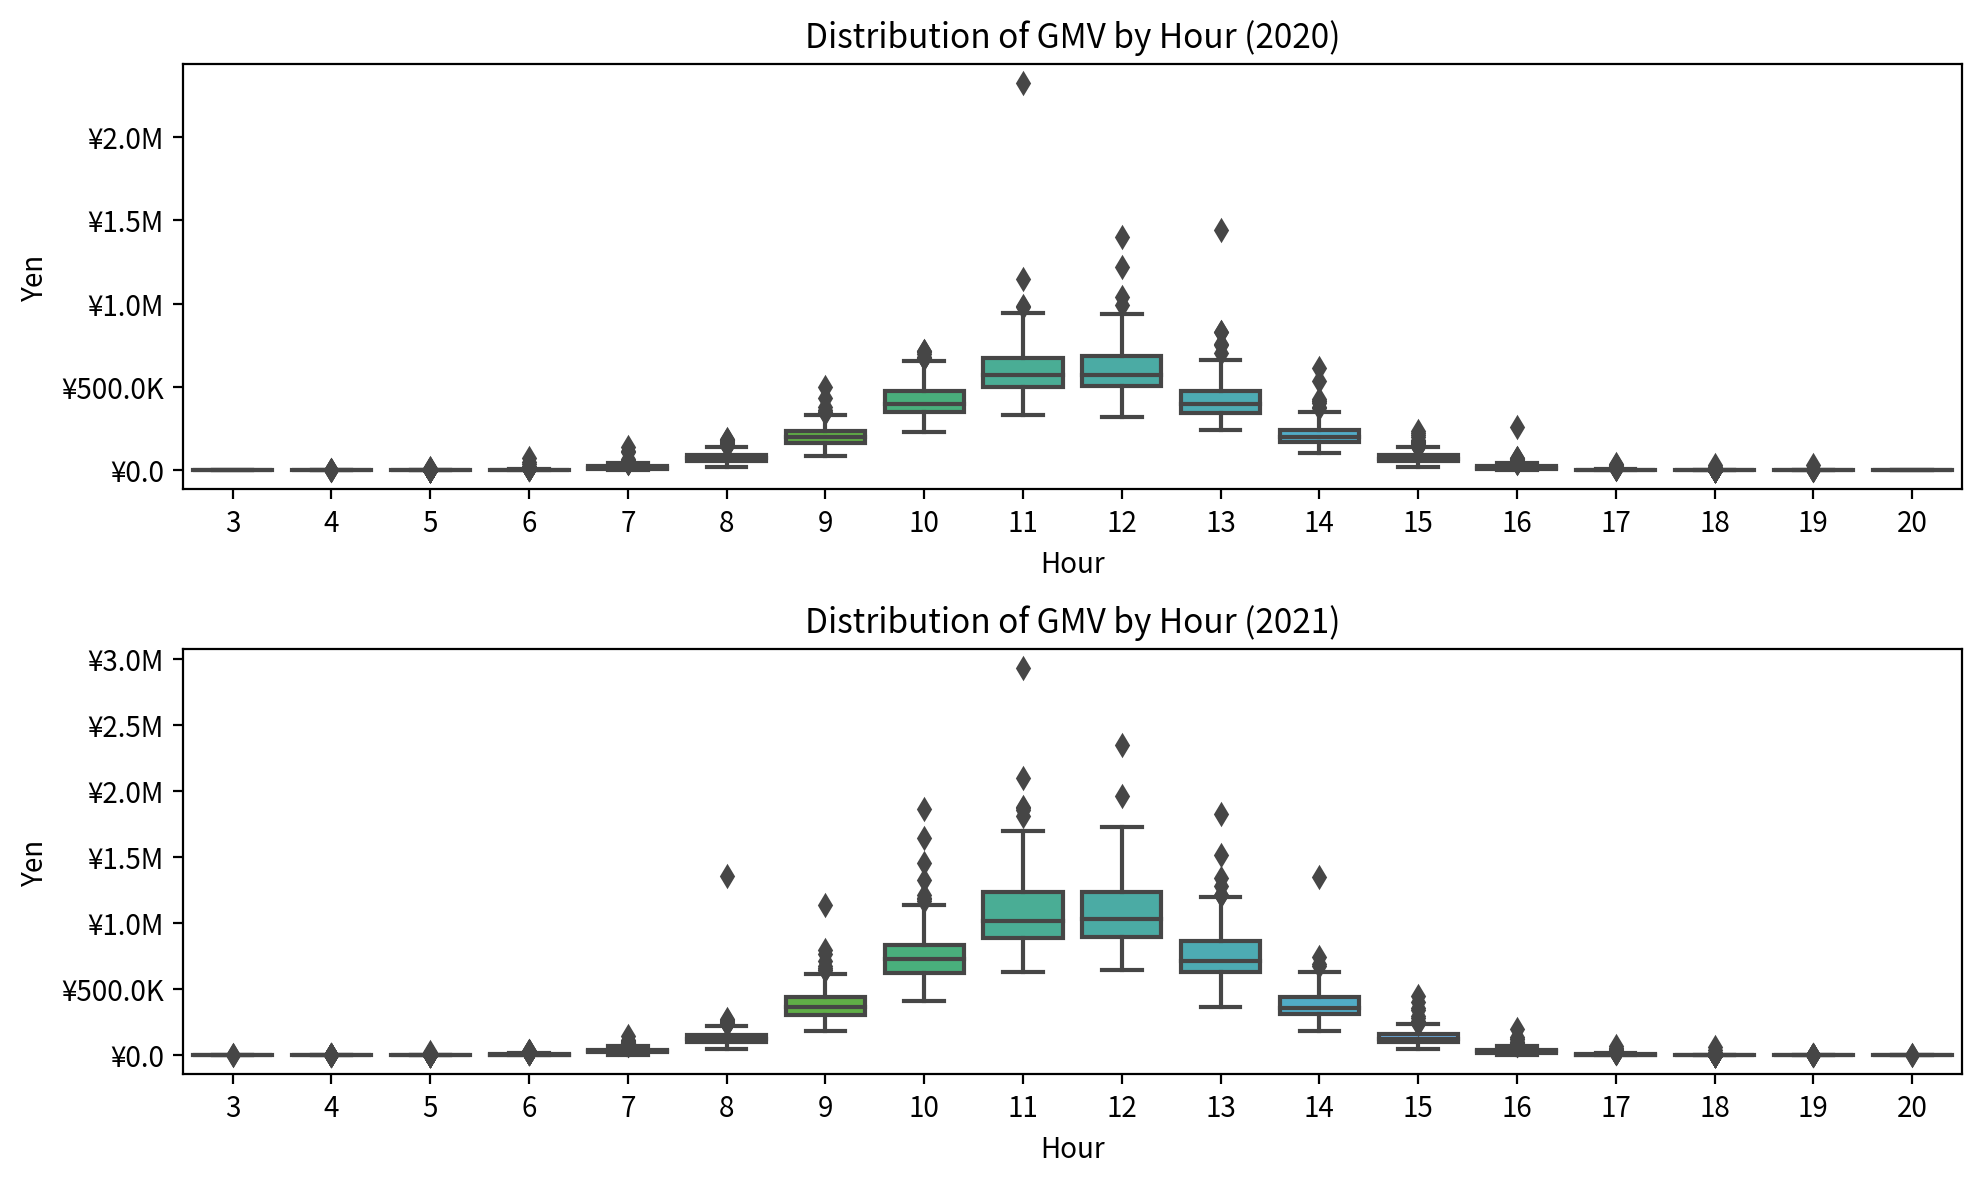

In [23]:
_, da_long = prep_data_date_by_season(df, 'hour')
mk_boxplot_gmv_by_season(da_long, xvar='hour', yvar='GMV')

- GMV peak happens between 11:00 and 13:00.
- GMV smaller peak happens between 10:00 and 11:00 and between 13:00 and 14:00.
- GMV 3rd wave (even smaller) happens 9:00 and 10:00 and 14:00 and 15:00.
- GMV is tiny for the rest of times.

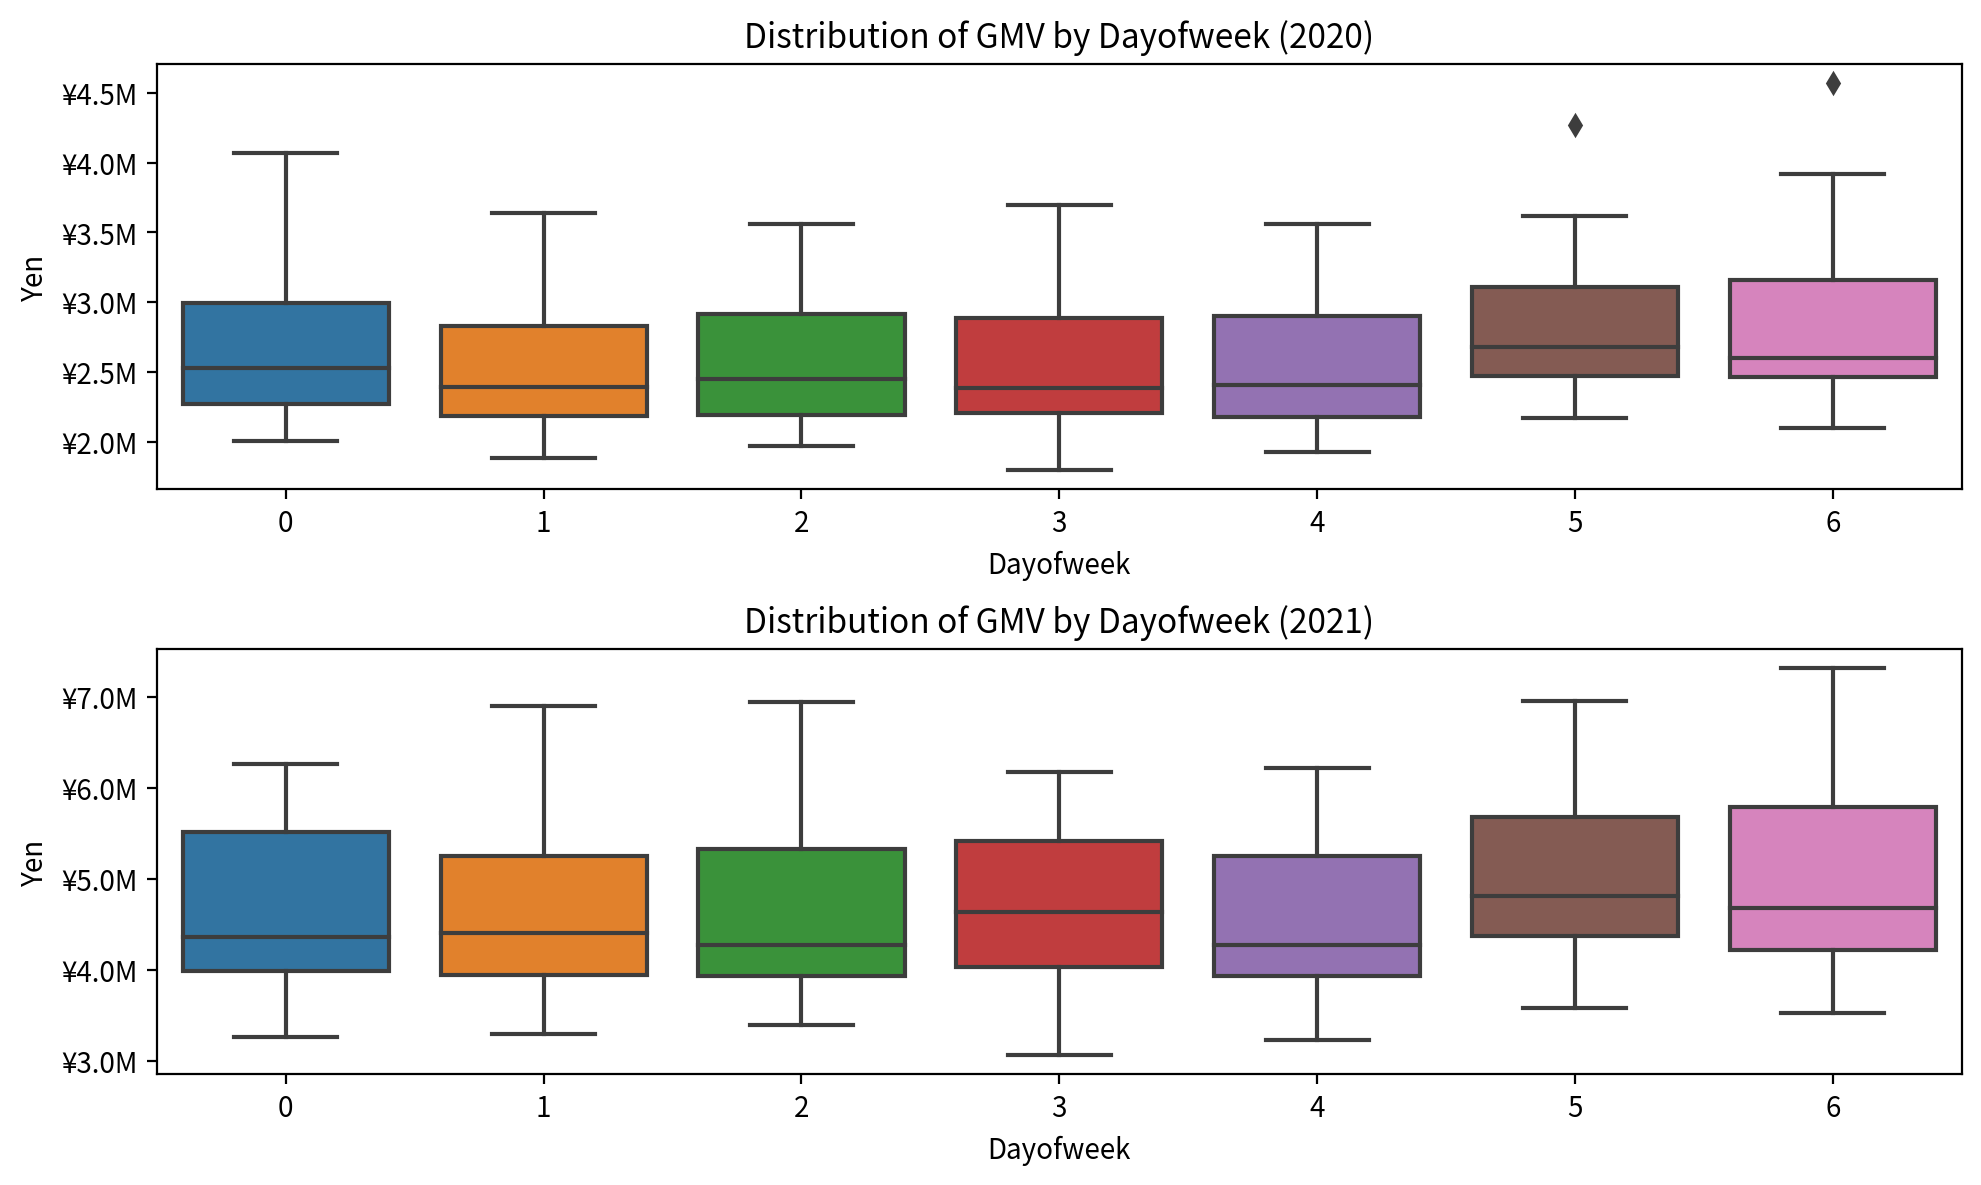

In [24]:
_, da_long = prep_data_date_by_season(df, 'dayofweek')
ha = da_long[da_long.GMV != 0].sort_values('dayofweek')
mk_boxplot_gmv_by_season(ha, xvar='dayofweek', yvar='GMV') 

GMV on the weekeends is a little bigger than during the weekdays. 
This difference doesn't seem to be significant since the bodies of the boxes overlap a lot.

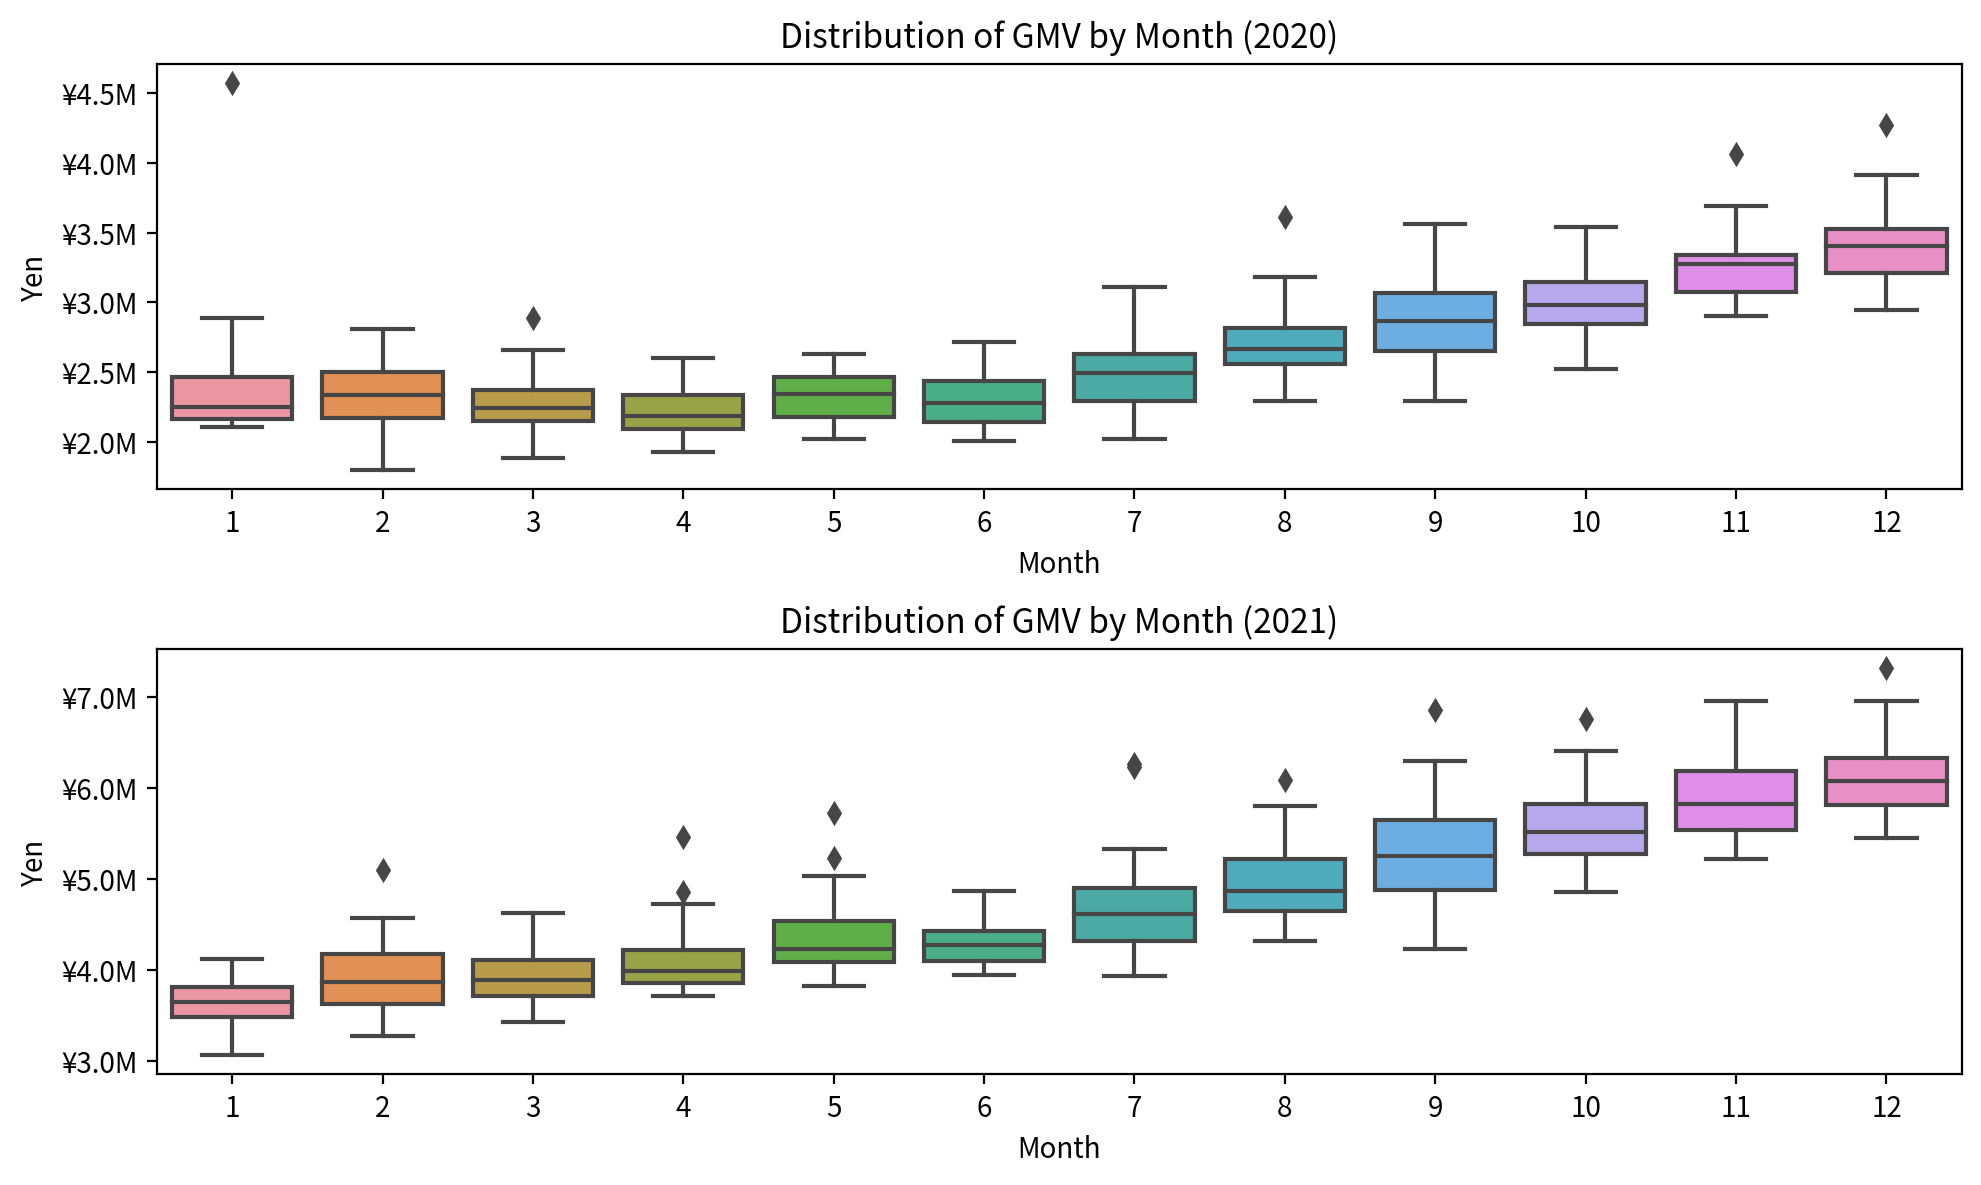

In [25]:
_, da_long = prep_data_date_by_season(df, 'month')
ha = da_long[da_long.GMV != 0].copy()
ha['month'] = ha['month'].astype(int)
ha = ha.sort_values('month')
mk_boxplot_gmv_by_season(ha, xvar='month', yvar='GMV')

GMVs in later months (July to December) are significantly bigger than earlier months (January to June).

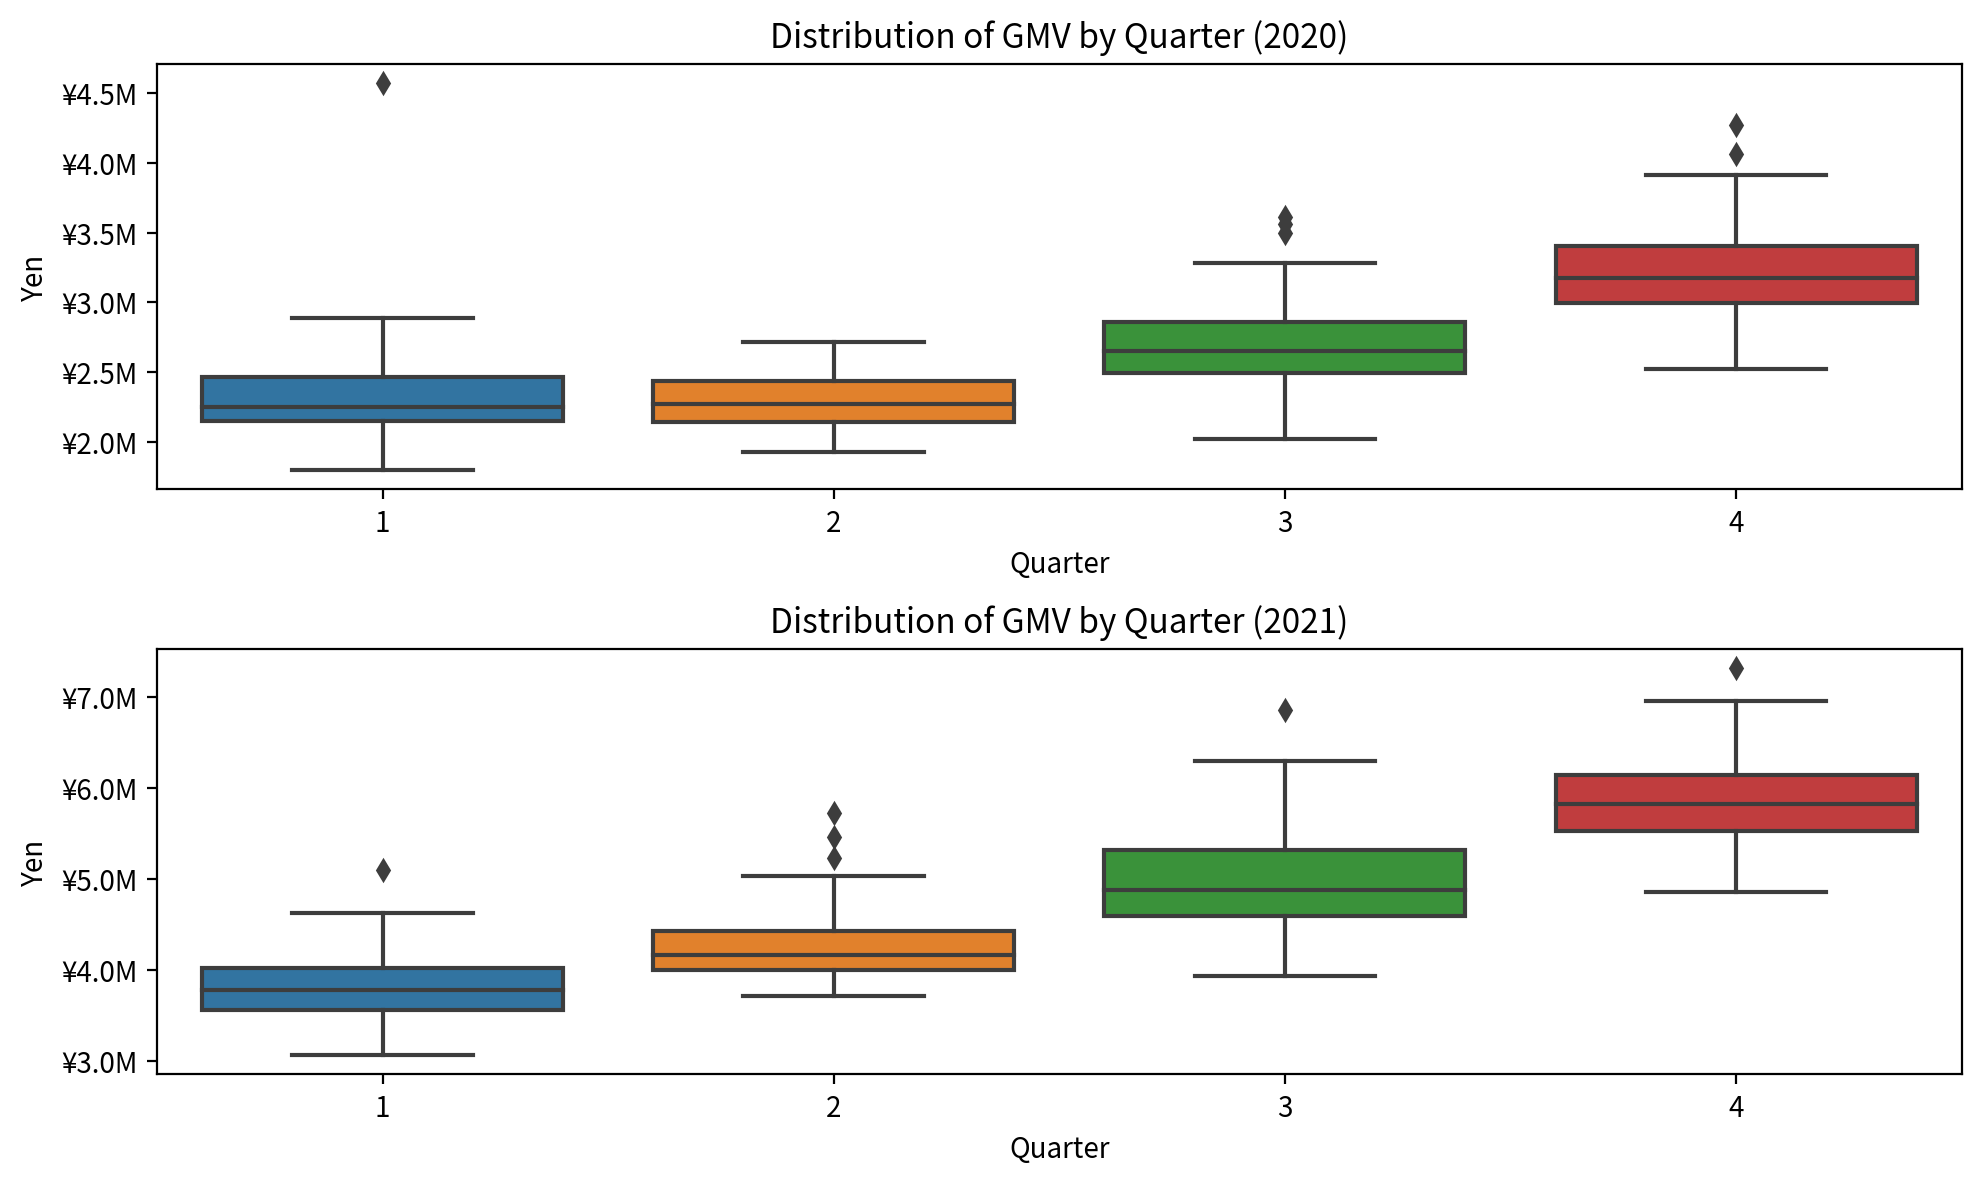

In [26]:
_, da_long = prep_data_date_by_season(df, 'quarter')
ha = da_long[da_long.GMV != 0]
mk_boxplot_gmv_by_season(ha, xvar='quarter', yvar='GMV')

GMVs in Q3 and Q4 are significantly bigger than Q1 and Q2.

## Forecast GMV for each user for the month of January 2022

Methodology: XGBOOST 

1. Aggregate monthly GMV by user.
2. Baseline: use the current month spend as the forecast for the next month, and perform walk-forward validation.
3. Train XGBOOST model on age, gender, and all available months' spend to predict next month spend.
   For example, when next month is 1, train a model on gender and age and use it to forecast month 1 spend for new users. 
   When next month is 2, train a model on gender and age and month 1 spend and use it to forecast month 2 spend. 
   When next month is 10, train a model on gender and age and month 1, 2, ..., 9 spend and use it to forecast month 10 spend.
   Do this for next 1, 2, ..., 23 months. 
   For each next month,
    - Structure the data so that each row is a user, with age, gender, and its historical monthly spends as columns.
        - Create both training and forward-validation sets with care! Both training and forward-validation sets should
          have the same number of rows and columns. The monthly spend columns of the forward-validation set are those
          of the training set shifted to the right by 1 column.
    - Run grid search with 10-fold CV vertically across users on training set to select the best model. 
    - Perform walk-forward validation.
4. Compare walk-forward validation performances of XGBOOST and baseline. Hopefully, XGBOOST beats the naive forecast.
5. Forecast Jan 2022 spend for each user using the XGBOOST models. 

In [27]:
# aggregate monthly GMV for each user
monthly_df_by_user = pd.pivot_table(
    df, 
    index=['user_id', 'age', 'gender'],
    columns='yearmon',
    values=['amount'],
    aggfunc='sum',
    fill_value=0 # (optional) also runs without filling the NAs
    )
# clean up columns and index
monthly_df_by_user.columns = monthly_df_by_user.columns.get_level_values(1).astype(str)
monthly_df_by_user.columns.name = None
monthly_df_by_user = monthly_df_by_user.reset_index([1,2])
# sanity check
print(monthly_df_by_user.index.nunique() == df.user_id.nunique()) 

# one-hot encode gender
monthly_df_by_user = pd.get_dummies(monthly_df_by_user, columns=['gender'])\
    .drop(columns=['gender_OTHER'])\
    .rename(columns={'gender_F': 'is_female', 'gender_M': 'is_male'})
    
# reorder the columns 
profile_cols = ['is_female', 'is_male', 'age']
month_cols = [col for col in monthly_df_by_user.columns if col not in profile_cols]
mons_cnt = len(month_cols)
monthly_df_by_user = monthly_df_by_user[profile_cols + month_cols]
monthly_df_by_user.head()

True


is_female  is_male    age  2020-01  \
user_id                                                                    
00073cc2-c801-c67c-d039-fca63c78c6a9          0        1  19.00        0   
000b6710-f8b4-ddd4-1913-90c7d424fccf          0        1  73.00        0   
00183cfe-ceb0-9220-7984-f33f61c61ae4          1        0  27.00    25306   
001b10c4-0ec1-68c9-a059-0a44159119bd          1        0  27.00     6222   
001cfd71-1996-2ffe-d382-4e7cd476ef88          0        0 999.00        0   

                                      2020-02  2020-03  2020-04  ...  2021-06  \
user_id                                                          ...            
00073cc2-c801-c67c-d039-fca63c78c6a9        0        0        0  ...     8333   
000b6710-f8b4-ddd4-1913-90c7d424fccf        0        0        0  ...    12430   
00183cfe-ceb0-9220-7984-f33f61c61ae4    66821    29863    16683  ...    36912   
001b10c4-0ec1-68c9-a059-0a44159119bd    23162    49788     5444  ...     7524   
001cfd71-1996-2ffe-d382-4e7cd476ef88        0        0        0  ...        0   

                                      2021-07  2021-08  2021-09  2021-10  \
user_id                                                                    
00073cc2-c801-c67c-d039-fca63c78c6a9    14324     8987     9249    23922   
000b6710-f8b4-ddd4-1913-90c7d424fccf    23740    15545    10373    11266   
00183cfe-ceb0-9220-7984-f33f61c61ae4    59514    12603    34045    38803   
001b10c4-0ec1-68c9-a059-0a44159119bd     2438    10663     5352    49218   
001cfd71-1996-2ffe-d382-4e7cd476ef88        0        0        0        0   

                                      2021-11  2021-12  
user_id                                                 
00073cc2-c801-c67c-d039-fca63c78c6a9    14355    19123  
000b6710-f8b4-ddd4-1913-90c7d424fccf    27381    34142  
00183cfe-ceb0-9220-7984-f33f61c61ae4    36756    35764  
001b10c4-0ec1-68c9-a059-0a44159119bd     5118    13496  
001cfd71-1996-2ffe-d382-4e7cd476ef88        0    39937  

[5 rows x 27 columns]

### Baseline

Use the current month spend as the forecast for the next month. This naive approach is often difficult to beat! 

In [28]:
# walk-forward validation of the baseline
baseline_valid_rmses = []
for i in range(1, mons_cnt): # next month index
    next_month = month_cols[i]
    curr_month = month_cols[i-1]
    subdf = monthly_df_by_user[[curr_month, next_month]]
    subdf.columns = ['yhat', 'ytru']
    subdf = subdf.dropna()
    rmse = metrics.mean_squared_error(subdf['ytru'], subdf['yhat'], squared=False)
    baseline_valid_rmses.append(rmse)

msg = '''When simply using current month spend as estimate for next month for each user, 
we can expect an average RMSE of {:,.0f} across all users. The error can be as best as {:,.0f} or as worse as {:,.0f}.'''\
    .format(np.mean(baseline_valid_rmses), np.min(baseline_valid_rmses), np.max(baseline_valid_rmses))
print(msg)

When simply using current month spend as estimate for next month for each user, 
we can expect an average RMSE of 20,044 across all users. The error can be as best as 12,437 or as worse as 32,152.


### XGBOOST

- Use age and gender and all available months' spendings as features, train xgboost model to predict next month's spend.
- Perform walk-forward validation and compare against the baseline.
- Forecast Jan 2022 spend for each user using the XGBOOST models.

In [31]:
use_cached_models = True # set to False to re-train, which takes ~100 minutes
saved_models_fname = 'xgboost_best_fits.pkl'
saved_xgboost_valid_rmses = 'xgboost_valid_rmses.pkl'

In [15]:
if use_cached_models:
    with open(saved_models_fname, 'rb') as f:
        xgboost_best_fits = pickle.load(f)
    with open(saved_xgboost_valid_rmses, 'rb') as f:
        xgboost_valid_rmses = pickle.load(f)        
else:
    xgboost_best_fits = []
    xgboost_valid_rmses = []
    for i in range(1, mons_cnt): # next month index
        # i = 1 # when i = 1, only use age and gender as features 
        print('Next month index:', i)
        # prep training and forward-validation sets 
        subdf = monthly_df_by_user[profile_cols + month_cols[:i+1]].dropna()
        train_cols = profile_cols + month_cols[:i]
        valid_cols = profile_cols + month_cols[1:i+1]
        # print(month_cols[i])
        # print(train_cols)
        # print(valid_cols)
        subdf_train = subdf[train_cols]
        subdf_valid = subdf[valid_cols]
        # print(subdf_train.columns)
        # print(subdf_valid.columns)
        newcols = ['lag{}'.format(j) for j in range(i-1, 0, -1)] + ['target']
        subdf_train.columns = subdf_valid.columns = profile_cols + newcols
        # print(subdf_train.columns)
        # print(subdf_valid.columns)

        # separate y from X
        yvar = 'target'
        xvars = [col for col in subdf_train.columns if col != 'target']
        ytrain, Xtrain = subdf_train[yvar], subdf_train[xvars]
        yvalid, Xvalid = subdf_valid[yvar], subdf_valid[xvars]

        # set up xgboost regressor, which doesn't require features to be on similar scale
        xgb_reg_spec = XGBRegressor(
            objective="reg:squarederror",   
            random_state=123
        )

        # set up a grid to look for the best parameters. 
        # can enlarge the grid when running on powerful machines.
        xgb_reg_model = GridSearchCV(
            estimator=xgb_reg_spec, 
            param_grid=dict(
                learning_rate = [0.1, 0.012, 0.015, 0.018, 0.019, 0.2],
                max_depth = [3, 4, 6],
                subsample = [0.6, 0.8],
                colsample_bytree = [0.6, 0.8], 
                nthread = [4],
                seed = [42]
            ),
            scoring = 'neg_mean_absolute_error',
            refit   = True,
            cv      = 10
        )

        # select best model using cv on training set over the param grid
        xgb_reg_model.fit(Xtrain, ytrain)
        print("Best params:", xgb_reg_model.best_params_)
        print("Internal CV score: {:.3f}, Validation score of the best model: {:.3f}"\
            .format(xgb_reg_model.best_score_, xgb_reg_model.score(Xvalid, yvalid)), 
            end='\n\n')

        # predict on validation set and calc validation rmse 
        df_pred = yvalid.to_frame()
        df_pred['xgb_pred'] = xgb_reg_model.predict(Xvalid)
        rmse = metrics.mean_squared_error(df_pred['target'], df_pred['xgb_pred'], squared=False)

        # collect the best model and validation rmse
        xgboost_best_fits.append(xgb_reg_model)
        xgboost_valid_rmses.append(rmse)    
        
    # save the models and rmses cuz it takes time to run    
    with open(saved_models_fname, 'wb') as f:
        pickle.dump(xgboost_best_fits, f)    
    with open(saved_xgboost_valid_rmses, 'wb') as f:
        pickle.dump(xgboost_valid_rmses, f)

Next month index: 1
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.012, 'max_depth': 3, 'nthread': 4, 'seed': 42, 'subsample': 0.8}
Internal CV score: -9586.426, Validation score of the best model: -8854.811

Next month index: 2
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'nthread': 4, 'seed': 42, 'subsample': 0.8}
Internal CV score: -4145.975, Validation score of the best model: -4138.174

Next month index: 3
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.018, 'max_depth': 4, 'nthread': 4, 'seed': 42, 'subsample': 0.8}
Internal CV score: -3818.401, Validation score of the best model: -3690.419

Next month index: 4
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.018, 'max_depth': 6, 'nthread': 4, 'seed': 42, 'subsample': 0.8}
Internal CV score: -3683.286, Validation score of the best model: -3994.651

Next month index: 5
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.018, 'max_depth': 6, 'nthread': 4, 'seed': 4

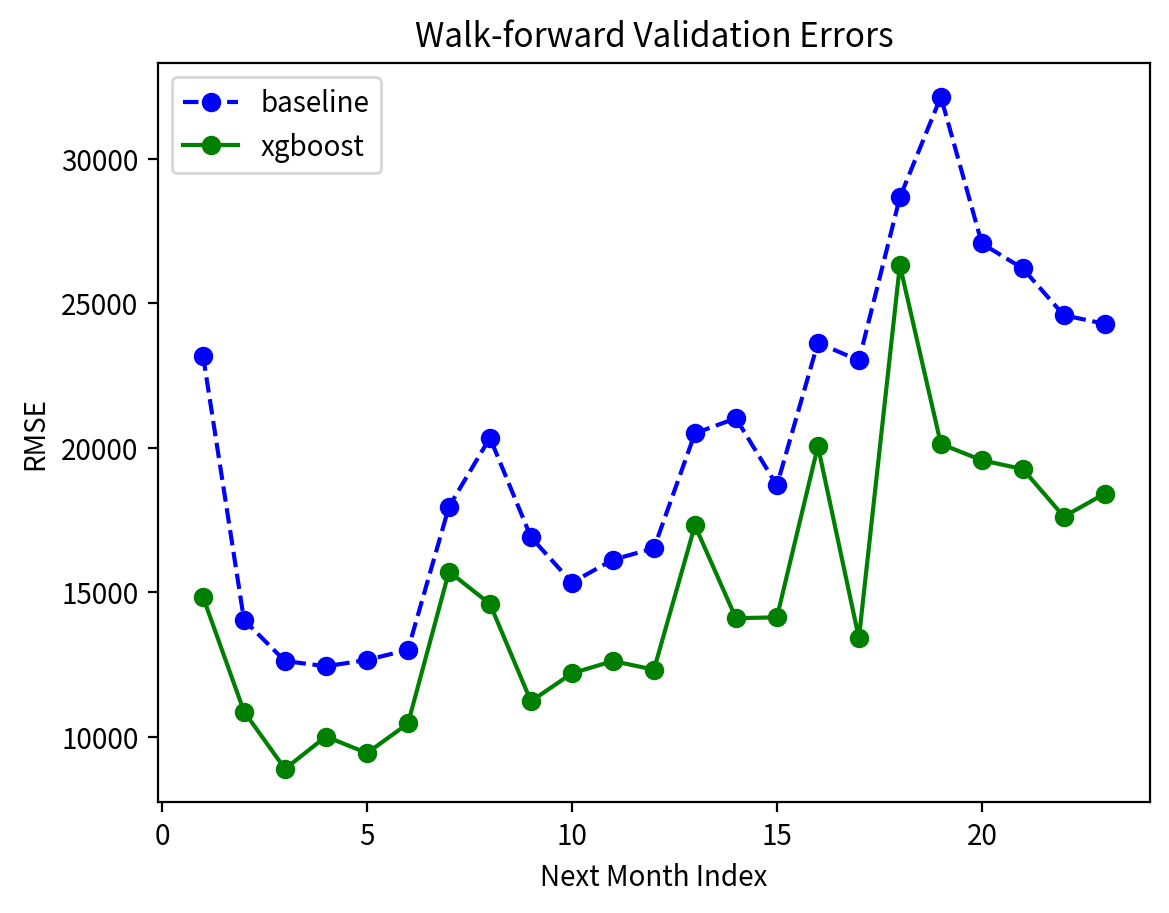

In [35]:
# compare XGBOOST against baseline on forward validation sets
next_month_indices = range(1, mons_cnt)
plt.plot(next_month_indices, baseline_valid_rmses, 'bo--')
plt.plot(next_month_indices, xgboost_valid_rmses, 'go-')
plt.title('Walk-forward Validation Errors')
plt.xlabel('Next Month Index')
plt.ylabel('RMSE')
plt.legend(["baseline", 'xgboost'])
plt.show()

XGBOOST beats the baseline. Yeah!

In [36]:
# forecast Jan 2022 spend for each user using each of the 23 xgboost models,
# so for each user, we'll get 23 forecasts for Jan 2022
lst_of_forecasts = []
for i in range(0, -23, -1):
    # i = -22 # 0, -1, -2, ..., -22
    # print(month_cols[i:])
    
    # extract the corresponding xgboost best fit
    mod_idx = -i
    # print(mod_idx)
    mod = xgboost_best_fits[mod_idx]

    # when i = 0, we're only using age and gender to make predictions

    # prep features 
    if i == 0:
        X = monthly_df_by_user[profile_cols].dropna()
    else: 
        X = monthly_df_by_user[profile_cols + month_cols[i:]].dropna()  
        newcols = ['lag{}'.format(-j) for j in range(i, 0)]   
        X.columns = profile_cols + newcols
        assert len(newcols) == X.shape[1]-3 # sanity check
    # print(X.head())

    # # make forecasts
    yhat = pd.DataFrame({'yhat_mod{}'.format(mod_idx): mod.predict(X)},
                        index=X.index) 
    lst_of_forecasts.append(yhat)
    
df_pred = pd.concat(lst_of_forecasts, axis=1)
assert len(df_pred) == len(monthly_df_by_user) 
df_pred.head(3)    

yhat_mod0  yhat_mod1  yhat_mod2  \
user_id                                                                 
00073cc2-c801-c67c-d039-fca63c78c6a9   4,324.15  17,353.85  14,358.75   
000b6710-f8b4-ddd4-1913-90c7d424fccf   5,330.67  22,927.58  18,535.15   
00183cfe-ceb0-9220-7984-f33f61c61ae4   5,542.07  23,812.20  22,851.99   

                                      yhat_mod3  yhat_mod4  yhat_mod5  \
user_id                                                                 
00073cc2-c801-c67c-d039-fca63c78c6a9  15,683.49  14,447.71  13,003.03   
000b6710-f8b4-ddd4-1913-90c7d424fccf  16,346.52  15,621.32  17,740.94   
00183cfe-ceb0-9220-7984-f33f61c61ae4  23,286.29  24,441.72  23,052.12   

                                      yhat_mod6  ...  yhat_mod16  yhat_mod17  \
user_id                                          ...                           
00073cc2-c801-c67c-d039-fca63c78c6a9  14,180.90  ...   14,232.94   13,775.69   
000b6710-f8b4-ddd4-1913-90c7d424fccf  17,391.81  ...   16,586.58   14,588.79   
00183cfe-ceb0-9220-7984-f33f61c61ae4  25,742.90  ...   25,855.72   23,678.34   

                                      yhat_mod18  yhat_mod19  yhat_mod20  \
user_id                                                                    
00073cc2-c801-c67c-d039-fca63c78c6a9   14,269.24   13,658.15   14,259.61   
000b6710-f8b4-ddd4-1913-90c7d424fccf   15,950.07   15,965.30   17,084.08   
00183cfe-ceb0-9220-7984-f33f61c61ae4   26,105.14   25,312.96   24,344.41   

                                      yhat_mod21  yhat_mod22  
user_id                                                       
00073cc2-c801-c67c-d039-fca63c78c6a9   14,846.51   15,611.07  
000b6710-f8b4-ddd4-1913-90c7d424fccf   16,968.93   16,404.19  
00183cfe-ceb0-9220-7984-f33f61c61ae4   27,151.40   24,307.47  

[3 rows x 23 columns]

In [37]:
# take the average of all 23 forecasts as the final forecast for each user
yforecast = df_pred.mean(axis=1)
yforecast.name = 'Jan 2022 GMV forecast'
yforecast.to_csv('Jan2022-GMV-forecast-for-each-user.csv')

## Forecast GMV for YayYay as a whole for each date in the month of January 2022

Methodology: Iterative Training and Walk-forward Validation.

1. Aggregate daily GMV for YayYay as a whole.
2. Feature engineering (date time features, external features, etc.).
3. Start with the following training and validation sets:
   - training set: daily data of all 12 months in 2020 
   - validation set: daily data of Jan 2021.
4. Model selection on the training set:
   - Examine trend, seasonality, and cyclic behavior of the target series on the training set.
   - Select best model parameters based on observations.
5. Train model and make forecasts for the next 1, 2, ..., 30, 31 days. Calculate prediction errors. 
6. Shift both the training and validation sets to the right by 1 month. Repeat step 3 - 5.

### Data Prep

In [38]:
# aggregate daily GMV for YayYay as a whole
daily_df = df.groupby('date').aggregate({
    'amount': 'sum', # gmv 
    # create date time features that might be predictive
    'week': 'mean',  
    'dayofweek': 'mean', 
    # 'is_weekend': 'mean', 
    'is_holiday': 'mean', 
    }).asfreq('D').rename(columns={'amount': 'gmv'})
daily_df['week'] = daily_df['week'].astype(int)
daily_df['dayofweek'] = daily_df['dayofweek'].astype(int)
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)
daily_df.index.name = None
daily_df.head()

gmv  week  dayofweek  is_holiday
2020-01-01  2633813     1          2           1
2020-01-02  2115625     1          3           0
2020-01-03  2110395     1          4           0
2020-01-04  2415564     1          5           0
2020-01-05  2346069     1          6           0

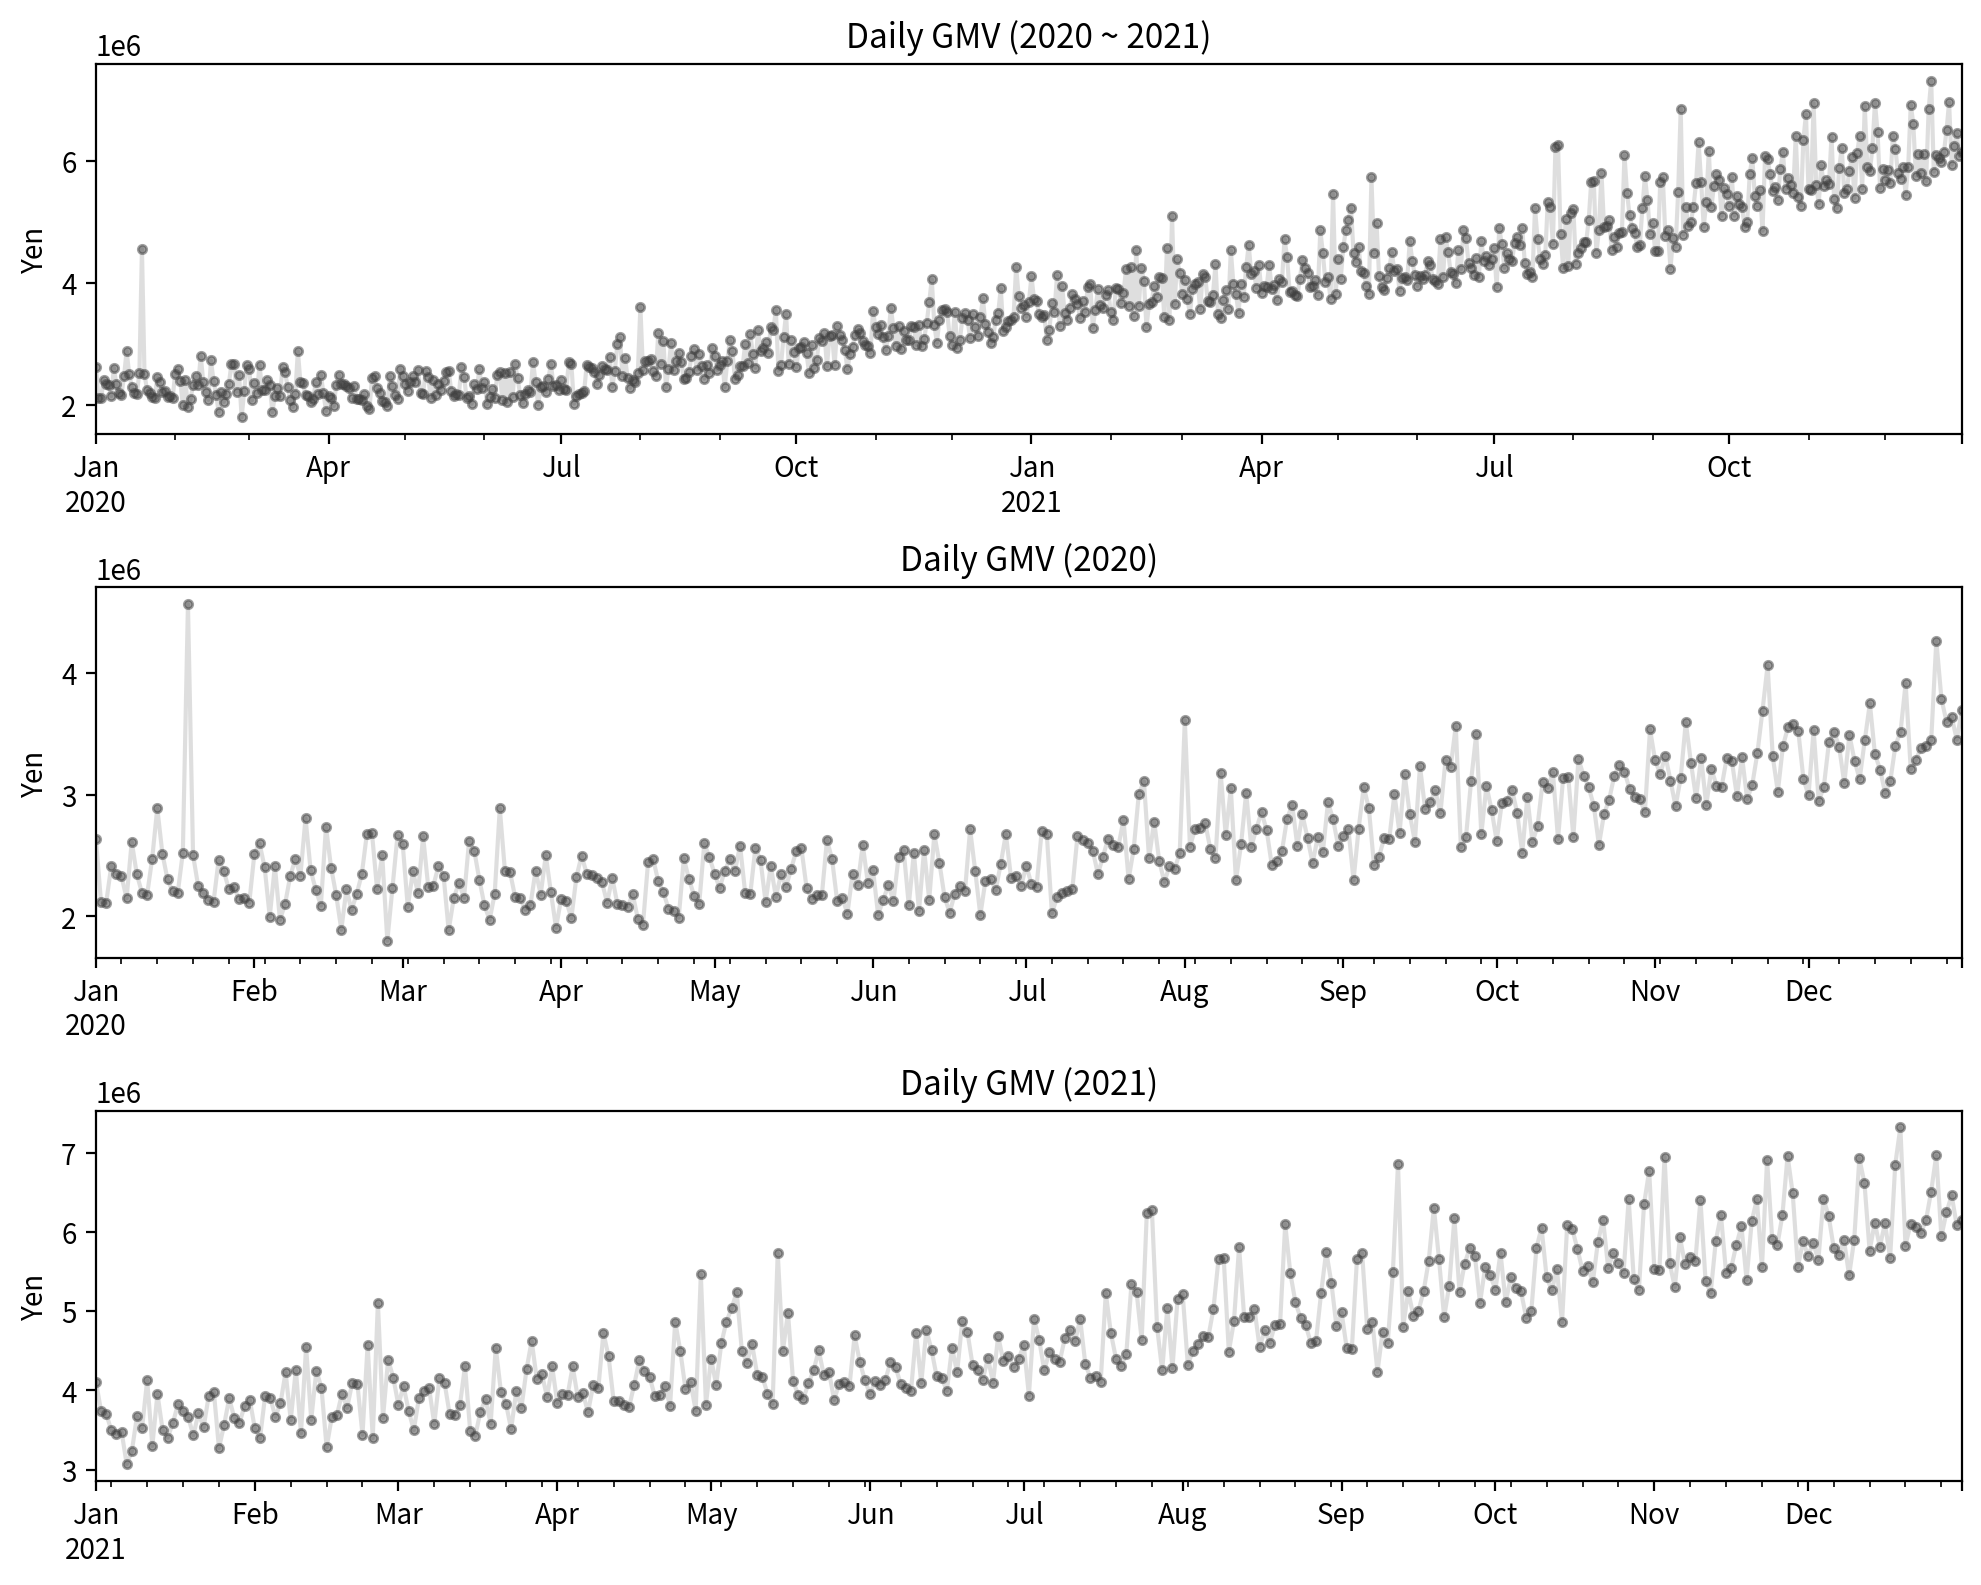

In [39]:
# plot the target series over 2 years and for 2020 and 2021 separately
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 8))
daily_df['gmv'].plot(**plot_params, alpha=0.5, ax=ax0)
ax0.set(title='Daily GMV (2020 ~ 2021)', ylabel='Yen')
daily_df.loc[:'2020-12-31', 'gmv'].plot(**plot_params, alpha=0.5, ax=ax1)
ax1.set(title='Daily GMV (2020)', ylabel='Yen')
daily_df.loc['2021-01-01':, 'gmv'].plot(**plot_params, alpha=0.5, ax=ax2)
ax2.set(title='Daily GMV (2021)', ylabel='Yen')
plt.tight_layout()
plt.show()

The daily GMVs show a quadratic trend. It's reasonable to assume the trend continues into 2022 and beyond.

In [40]:
# as a first attempt, let's use 2020 data for training and Jan 2021 data for 
# validation. 
train = daily_df[:'2020-12-31']
valid = daily_df['2021-01-01':'2021-01-31']
print('Number of records for training:', len(train))
print(train.tail(3), end='\n\n')
print('Number of records for validation:', len(valid))
print(valid.head(3))

Number of records for training: 366
                gmv  week  dayofweek  is_holiday
2020-12-29  3641389    53          1           0
2020-12-30  3453809    53          2           0
2020-12-31  3693409    53          3           0

Number of records for validation: 31
                gmv  week  dayofweek  is_holiday
2021-01-01  4111455    53          4           1
2021-01-02  3741056    53          5           0
2021-01-03  3706206    53          6           0


### Trend, Seasonality, and Cycles of the target series

Examine the trend, seasonality, and cyclic behavior of the daily GMV series on the training set.

In [41]:
ytrain = train['gmv']
Xtrain = train.drop(columns = ['gmv'])

#### Is there a trend?

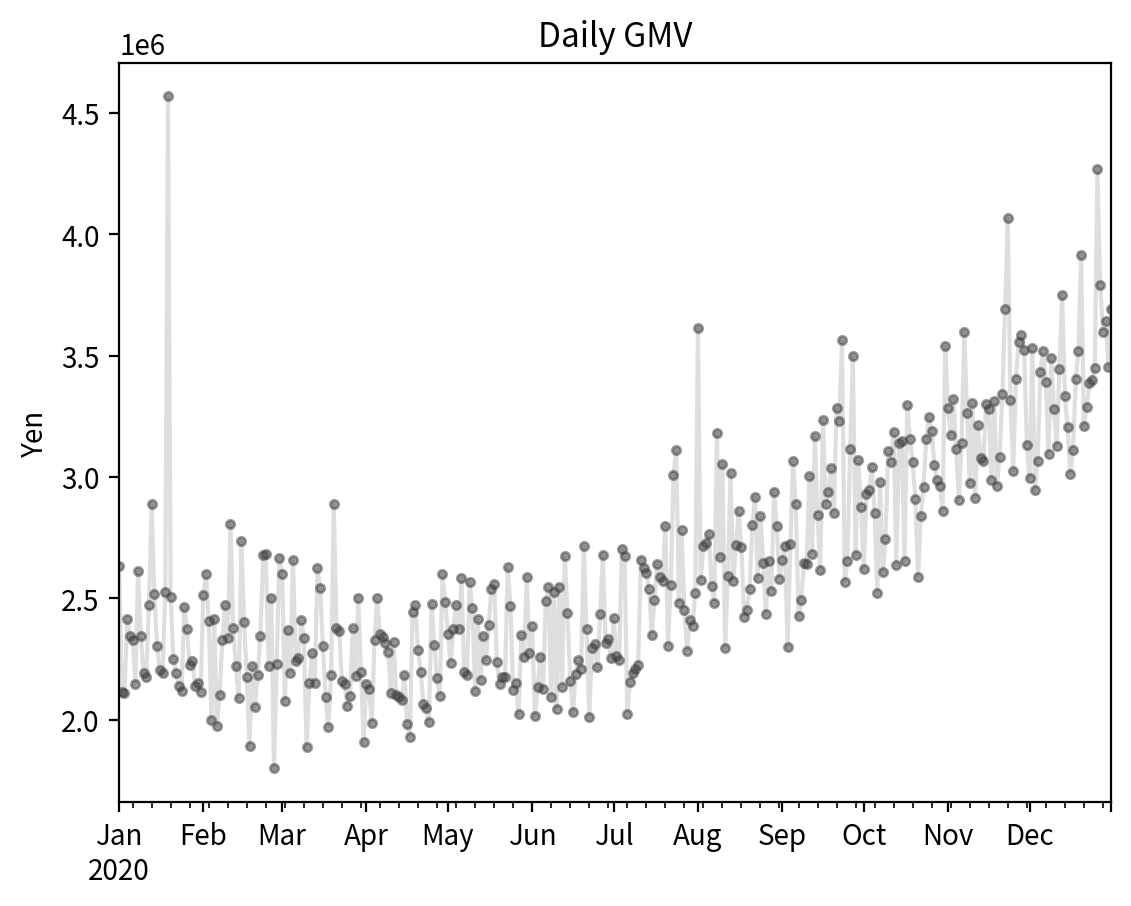

In [42]:
ax = ytrain.plot(**plot_params, alpha=0.5)
ax.set(title='Daily GMV', ylabel='Yen');

There's a clear 2nd order trend. Definitely non-stationary. Let's look at the first order differences.

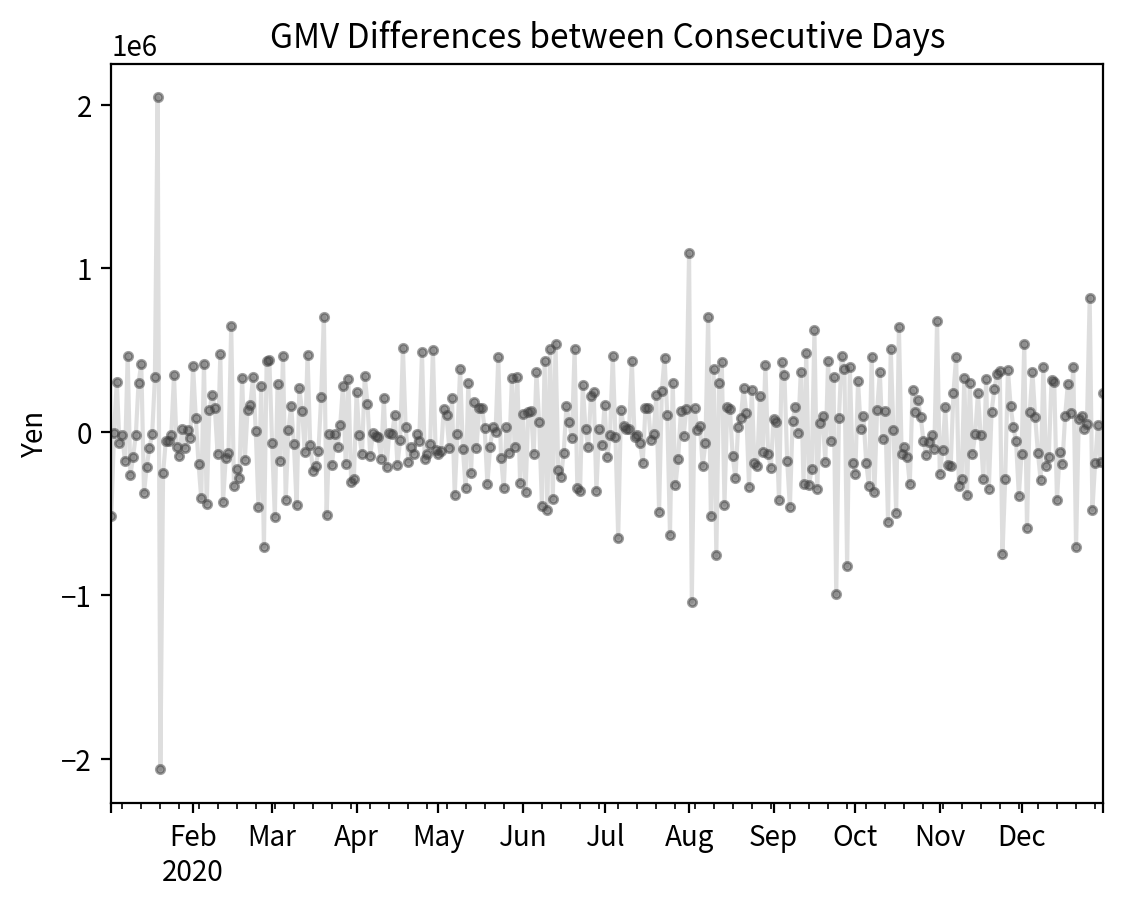

In [43]:
diff = ytrain.diff().dropna()
diff.name = 'GMV 1st order difference'
ax = diff.plot(**plot_params, alpha=0.5)
ax.set(title='GMV Differences between Consecutive Days', ylabel='Yen');

We see that the 1st order differences are distributed like white noise around zero except a few outliers. Looks like stationary. Let's check it formally using the augmented Dickey–Fuller test.

In [44]:
is_diff_stationary = check_stationarity(diff) 

p-value = 0.0, and the GMV 1st order difference time series is likely stationary.


So we can consider an ARIMA model and set `d=1`, which will model the 1st order differences under the hood.

#### Are there any seasonalities?

The outliers in the above plot took place at the end of December and in late January and early August. Was it because of the holidays? Let's check.

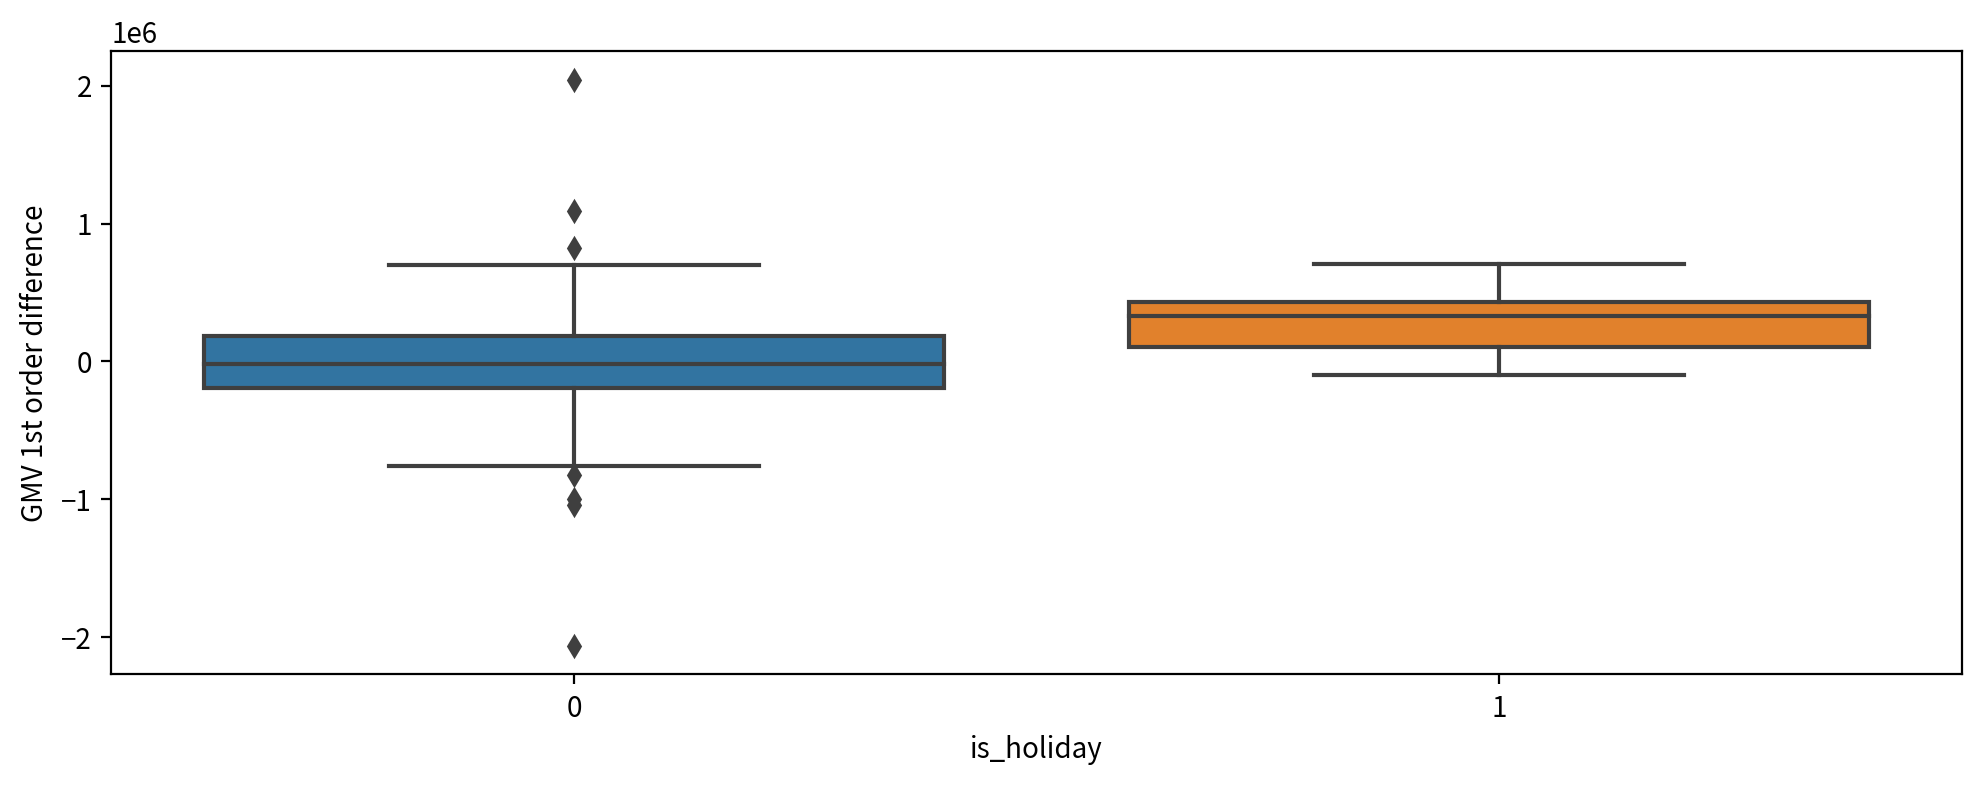

In [45]:
sns.boxplot(y=diff, x=Xtrain.loc[diff.index, 'is_holiday'])
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.tight_layout()

Seems like the 1st order differences are mostly above 0 with a tighter range during holidays. So we'll want to include `is_holiday` as a feature when we build the model. Let's also check if the 1st order differences show any weekly patterns.

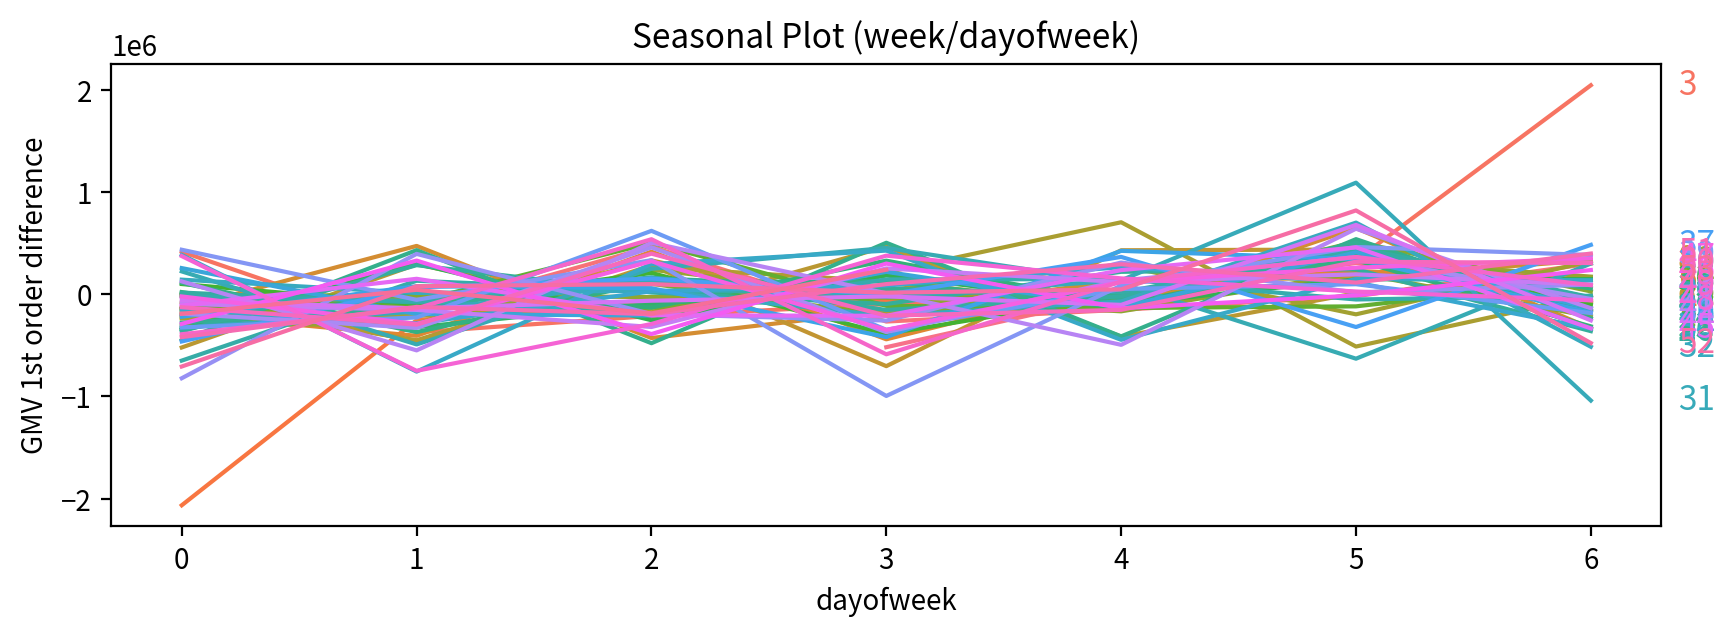

In [46]:
fig, ax0 = plt.subplots(1, 1, figsize=(10, 3))
seasonal_plot(Xtrain.loc[diff.index], y=diff, period="week", freq="dayofweek", ax=ax0);

There's a clear distinction between weekends and weekdays for the 3rd and 31st week. But it's difficult to tell if such patten is consistent week after week. Let's try a boxplot.

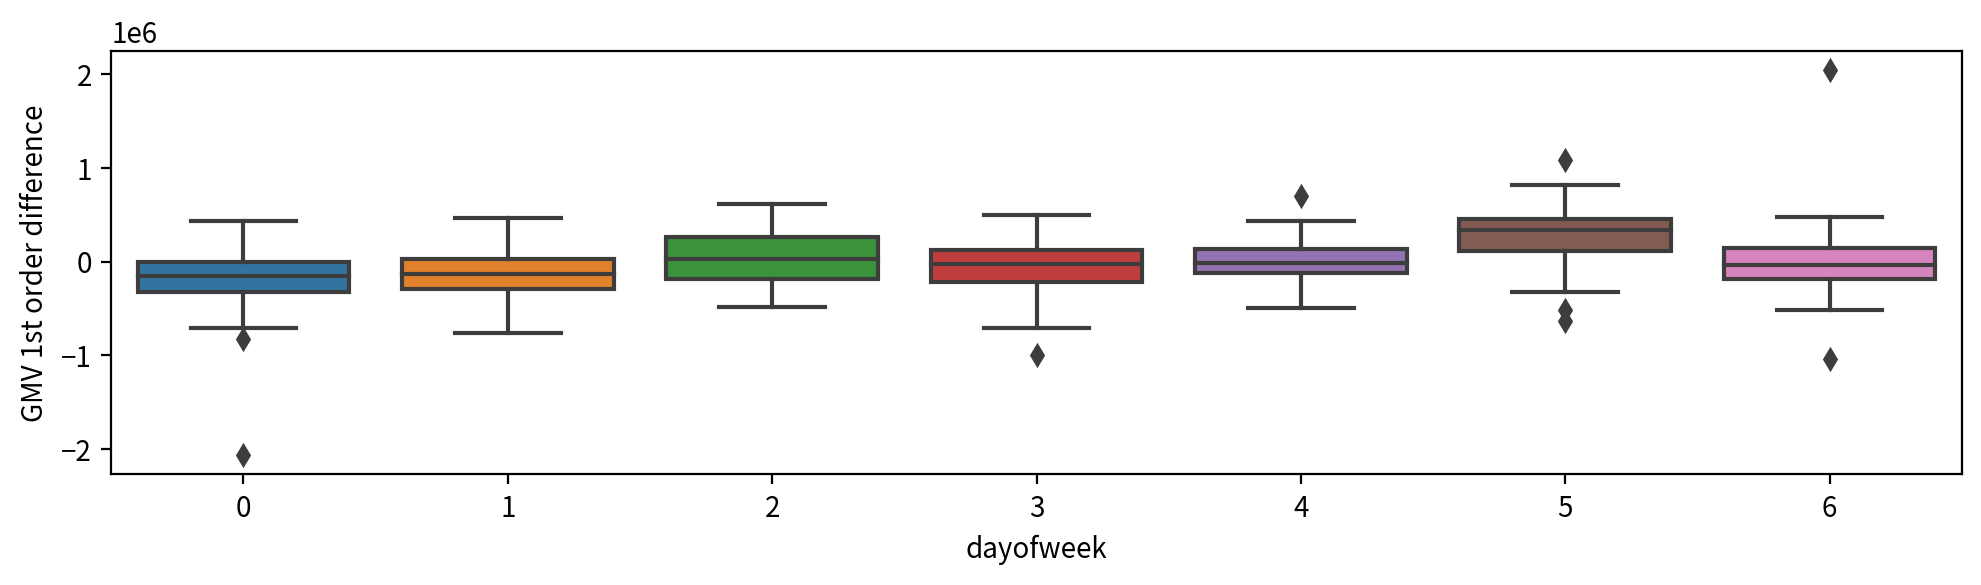

In [47]:
sns.boxplot(y=diff, x=Xtrain.loc[diff.index, 'dayofweek'])
fig = plt.gcf()
fig.set_size_inches(10, 3)
plt.tight_layout()

Now it's more clear that Wednesdays and Saturdays tend to behave a little different than the other days of the week. So we will also include `dayofweek` as a feature in the model. Let's now remove the seasonality effect and examine the residuals.

In [48]:
# one-hot encoding the categorical features
Xtrain_ready = pd.get_dummies(Xtrain, columns=['dayofweek'])\
    .drop(columns=['dayofweek_0', 'week'])
Xtrain_ready.head()

is_holiday  dayofweek_1  dayofweek_2  dayofweek_3  dayofweek_4  \
2020-01-01           1            0            1            0            0   
2020-01-02           0            0            0            1            0   
2020-01-03           0            0            0            0            1   
2020-01-04           0            0            0            0            0   
2020-01-05           0            0            0            0            0   

            dayofweek_5  dayofweek_6  
2020-01-01            0            0  
2020-01-02            0            0  
2020-01-03            0            0  
2020-01-04            1            0  
2020-01-05            0            1

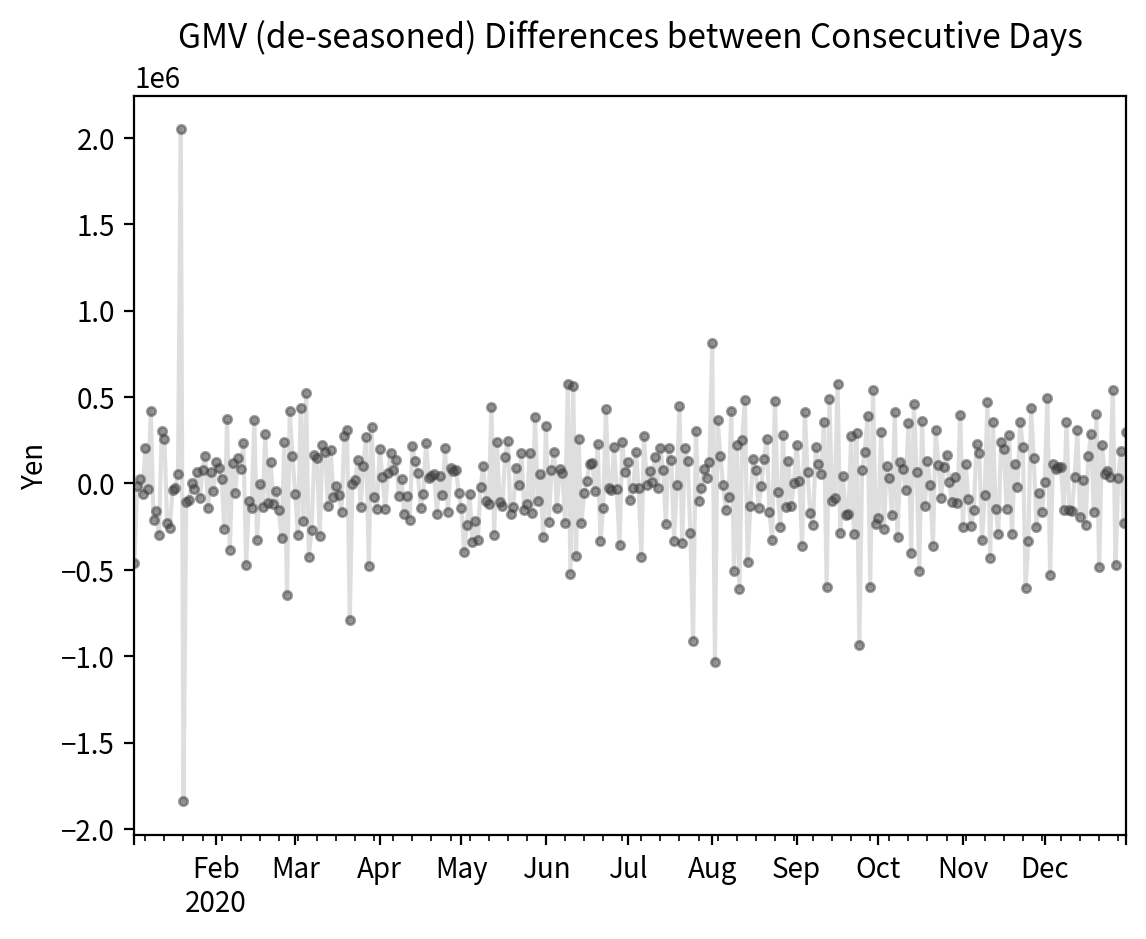

In [49]:
# fit a linear regression 
Xtmp = sm.add_constant(Xtrain_ready.loc[diff.index])
model = sm.OLS(diff, Xtmp).fit()
# print(model.summary())

# clac the residuals
yhat_diff = pd.Series(model.predict(Xtmp), index=diff.index)
residuals = diff - yhat_diff

# plot the residuals
ax = residuals.plot(**plot_params, alpha=0.5)
ax.set(title='GMV (de-seasoned) Differences between Consecutive Days', ylabel='Yen');

Except the two outliers in Jan 2020, the de-seasoned and detrend series looks really like white noise. Great.

#### What about autocorrelation and cyclic pattern?

So we took the 1st order differences of the GMV series to remove the quadratic trend and make the series stationary, and then we used a linear regression to remove weekly seasonality and holiday effects. We now have a de-trend and de-seasoned series and we're ready to examine its cyclic patterns with ACF and PACF plots.

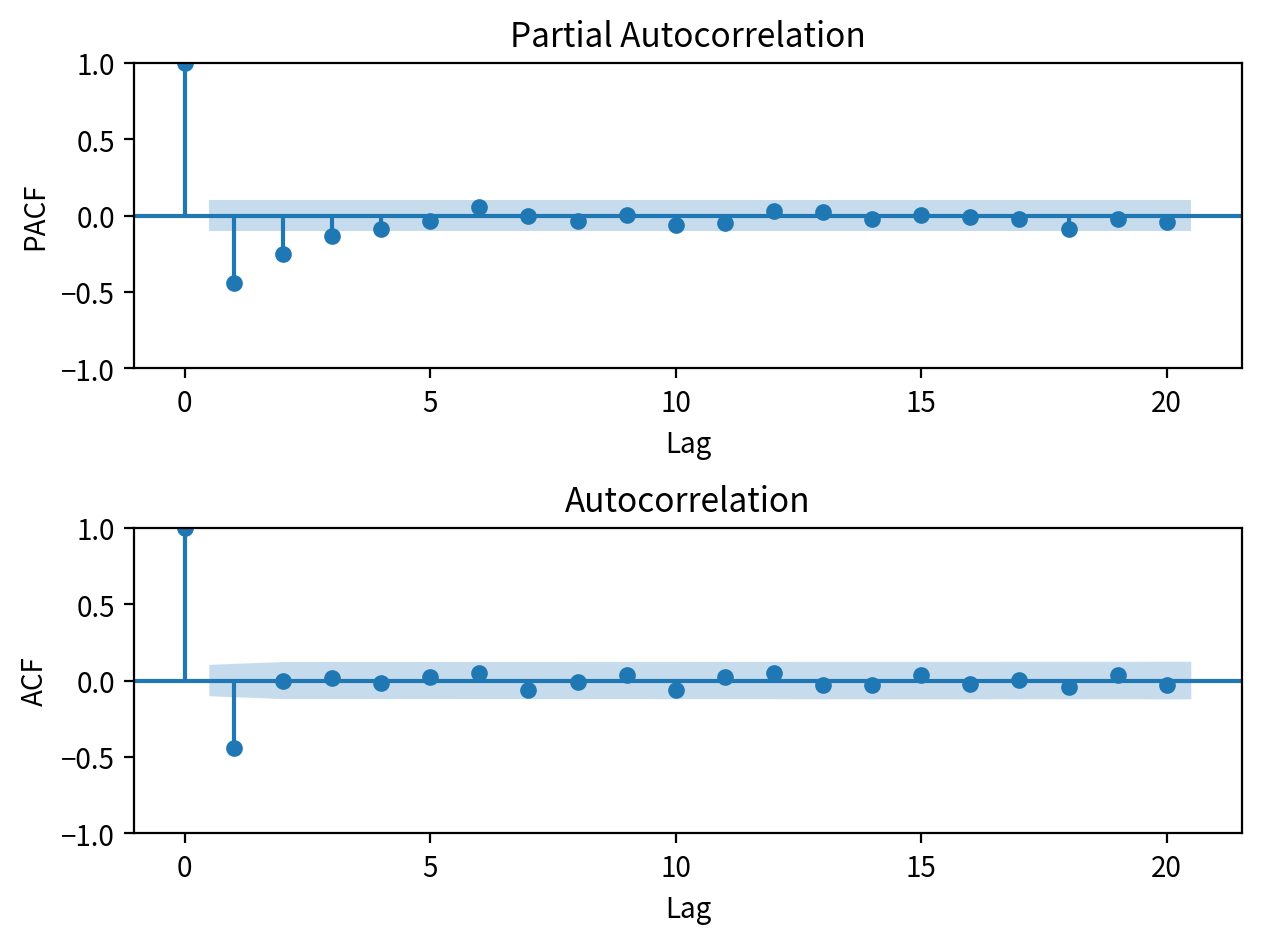

In [50]:
# plot ACF and PACF
fig, axs = plt.subplots(2)
plot_pacf(residuals, lags=20, method='ywm', ax=axs[0]) # partial autocorrelation 
axs[0].set_ylabel('PACF')
axs[0].set_xlabel('Lag')
plot_acf(residuals, lags=20, ax=axs[1])  # autocorrelation
axs[1].set_ylabel('ACF')
axs[1].set_xlabel('Lag')
plt.tight_layout();

We see ACF value is -0.5 at the 1st lag and is squashed within the blue band starting from the 2nd lag. On the other hand, the PACF value drops to zero after 3 lags, indicating that after accounting for the correlations with the 1st and 2nd lags, the de-trended and de-seasoned series is still correlated with the 3rd lag but not beyond. So 3 is a good choice for the lag order `p` and 1 is a good choice for the moving average order `q` in an ARIMA model.

In [51]:
# auto-select best lag order
mod = ar_select_order(residuals, maxlag=20, glob=False)
mod.ar_lags

[1, 2]

Let's also use the `ar_select_order()` function to automatically detect the best lag order, just to double check. It determines the best lag order as 2. If we look at the above PACF plot again, we can see either 2 or 3 or 4 wins.
 
So let's search for the best parameters across the following grid:
- `p`: 2, 3, 4
- `d`: 1
- `q`: 1

in an ARIMA model with `dayofweek` and `is_holiday` as external features.

#### Grid Search

In [52]:
yvalid = valid['gmv']
Xvalid = valid.drop(columns = ['gmv'])
Xvalid_ready = pd.get_dummies(Xvalid, columns=['dayofweek'])\
    .drop(columns=['dayofweek_0', 'week'])

In [53]:
HORIZON = 31
for p in range(2, 5):
        model = SARIMAX(ytrain, order=(p,1,1), exog=Xtrain_ready).fit(disp=False)
        yhat = model.forecast(steps=HORIZON, exog=Xvalid_ready)
        print("p={}, mean absolute percentage error = {}".format(p, MAPE(yvalid, yhat)))

p=2, mean absolute percentage error = 0.042692123332998946
p=3, mean absolute percentage error = 0.04316317444165301
p=4, mean absolute percentage error = 0.04386069917866081


Looks like `p=2` wins for this pair of training and validation sets.

### Iterative Train and Forward-Validate

Having found near optimal parameter choices `(d=1, q=1, p=2, 3, or 4)` for ARIMA, Let's now iteratively train and forward-validate all candidate models and analyze the prediction errors. At each iteration, we use 12 months of daily data to train and the following month of daily data for validation.

In [54]:
train_starts = [
    '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
    '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
    '2020-11-01', '2020-12-01', ]
train_stops = [
    '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30', 
    '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30', 
    '2021-10-31', '2021-11-30', ]
valid_starts = [
    '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
    '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
    '2021-11-01', '2021-12-01',]
valid_stops = train_stops[1:] + ['2021-12-31']
print(len(train_stops) == len(valid_starts) == len(valid_stops))

True


In [55]:
mapes = []
opt_ps = []
MAX_P = 5 # up to (MAX_P - 1) lags when picking the best lag order
for i in range(len(train_stops)):
    # split into training and forward-validation sets
    train = daily_df[train_starts[i]:train_stops[i]]    
    valid = daily_df[valid_starts[i]:valid_stops[i]]
    # separate y and X, and one-hot encode X
    ytrain = train['gmv']
    Xtrain = pd.get_dummies(train.drop(columns = ['gmv']), columns=['dayofweek'])\
        .drop(columns=['dayofweek_0', 'week'])
    yvalid = valid['gmv']
    Xvalid = pd.get_dummies(valid.drop(columns = ['gmv']), columns=['dayofweek'])\
        .drop(columns=['dayofweek_0', 'week'])
    # train and forward-validate models and calculate prediction errors
    horizon = (pd.to_datetime(valid_stops[i]) - pd.to_datetime(valid_starts[i])).days + 1
    min_error = 1; best_p = None
    for p in range(2, MAX_P):
        model = SARIMAX(ytrain, order=(p,1,1), exog=Xtrain).fit(disp=False)
        yhat = model.forecast(steps=horizon, exog=Xvalid)
        error = MAPE(yvalid, yhat)
        if error < min_error:
            min_error = error
            best_p = p
    mapes.append(min_error)
    opt_ps.append(best_p)

In [56]:
opt_ps # the most frequent best lag order is 4

[2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4]

In [57]:
mapes # mean absolute percentage errors for each iteration

[0.042692123332998946,
 0.0707518419186135,
 0.05909311746920408,
 0.04147102913134205,
 0.04871667583328838,
 0.03725110144934028,
 0.06218313131240187,
 0.04781478618683711,
 0.06718031288784583,
 0.05031840898667636,
 0.048448933248449,
 0.038880244155287104]

In [58]:
msg = '''When using an ARIMA(2,1,1), ARIMA(3,1,1), or ARIMA(4,1,1) with `dayofweek` and `is_holiday` 
as features to forecast the daily GMV values for the next month, we can expect an average error of {:.2%}, 
and the error can be as worse as {:.2%} or as best as {:.2%}. And we are using the mean absolute 
percentage error here.'''.format(np.mean(mapes), np.max(mapes), np.min(mapes))
print(msg)

When using an ARIMA(2,1,1), ARIMA(3,1,1), or ARIMA(4,1,1) with `dayofweek` and `is_holiday` 
as features to forecast the daily GMV values for the next month, we can expect an average error of 5.12%, 
and the error can be as worse as 7.08% or as best as 3.73%. And we are using the mean absolute 
percentage error here.


Because 4 is chosen as the best lag order for most of the iterations, we'll train an ARIMA(4, 1, 1) on 2021 daily GMV data, with `dayofweek` and `is_holiday` as external features, and we'll use it to forecast the daily GMV values in January 2022.

In [59]:
# prep training data
train = daily_df['2021-01-01':'2021-12-31']
ytrain = train['gmv']
Xtrain = pd.get_dummies(train.drop(columns = ['gmv']), columns=['dayofweek'])\
    .drop(columns=['dayofweek_0', 'week'])

# prep features for dates we'll forecast on
forecast_dates = pd.date_range('2022-01-01', '2022-01-31')
Xforecast = pd.DataFrame({
    'dayofweek': forecast_dates.dayofweek,
    'is_holiday': [0 if jp_holidays.get(dt) is None else 1 for dt in forecast_dates],
    }, index = forecast_dates)
Xforecast = pd.get_dummies(Xforecast, columns=['dayofweek'])\
    .drop(columns=['dayofweek_0'])
    
# print(Xtrain.tail(3), end='\n\n')
# print(Xforecast.head(3))

In [60]:
# train final model and make forecasts for daily values in Jan 2022
horizon = 31
model = SARIMAX(ytrain, order=(4,1,1), exog=Xtrain).fit(disp=False)
pred = model.get_forecast(steps=horizon, exog=Xforecast)
est = pred.predicted_mean
est.name = 'GMV forecast'
pred_ci = pred.conf_int(alpha=0.05)
df_forecast = pd.merge(est, pred_ci, left_index=True, right_index=True)
df_forecast.to_csv('daily-GMV-forecast-Jan2022.csv')